In this notebook, we will implement three convolutional neural network to segment Mesenchyme cells using light sheet microscopy (LSM) images. First, we will import the necessary packages.

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album



Installing the segmentation model pytorch package which comprises of the segmentation models.

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

Link the google drive to fetch the data that we want to analyse.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
indir="/content/drive/My Drive/Colab Notebooks/LSM_Segmentation_Dataset/"

Mounted at /content/drive


Fetching training, validation, and testing data from the drive. While running you can modify the location according to your drive.

In [5]:
DATA_DIR = '/content/drive/My Drive/LSM_Segmentation_Dataset/LSM_Segmentation_Dataset/DAPI-Cells'
TEST_DIR = os.path.join(DATA_DIR, 'Test')
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
VAL_DIR = os.path.join(DATA_DIR, 'Validation')

y_train_dir = os.path.join(TRAIN_DIR, 'Mesen_Mask')
x_train_dir = os.path.join(TRAIN_DIR, 'Original')

y_valid_dir = os.path.join(VAL_DIR, 'Mesen_Mask')
x_valid_dir = os.path.join(VAL_DIR, 'Original')

y_test_dir = os.path.join(TEST_DIR, 'Mesen_Mask')
x_test_dir = os.path.join(TEST_DIR, 'Original')

In [6]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

Define the class names and the corresponding label (RGB values)

In [7]:
# Get class names
class_names = ['cell', 'background']
# Get class RGB values
class_rgb_values = [[255, 255, 255], [0, 0, 0]]

In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['cell', 'background']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['cell', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


It is the helper function for data visualization. Specially, for the labels to represent the ground truth and precited segmentation in their one hot representation.

In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

Defining the pipelines for augmentation and preprocessing of the data.

In [10]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        # kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 

        # kernel = 1/3 * kernel

        # image = cv2.filter2D(image, -1, kernel)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

Visualizing the images, their corresponding ground truth and their one hot encoded representation.

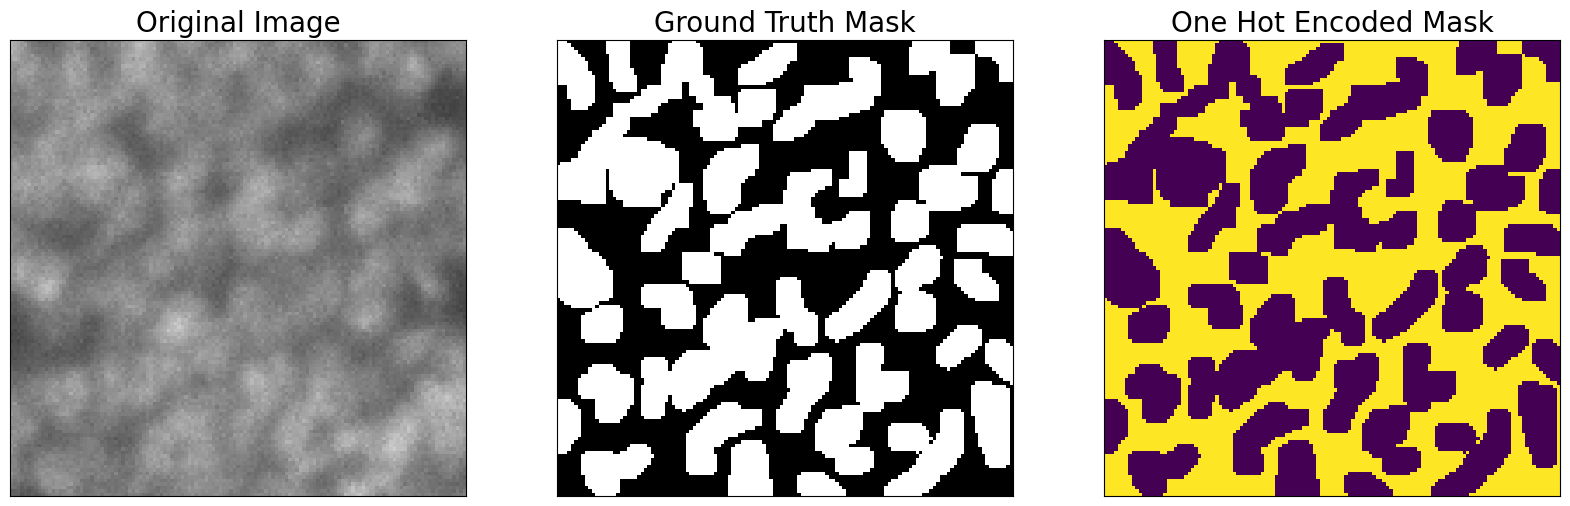

In [11]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

Here, we define the augmentation we are going to use for the training set. We resized the images to 128X128 resolution and then applied three augmentations to the training images. For testing and validation, only the resizing step is applied.

In [12]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=128, width=128, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        



    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.RandomCrop(height=128, width=128, always_apply=True),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

Visualize the augmented data.

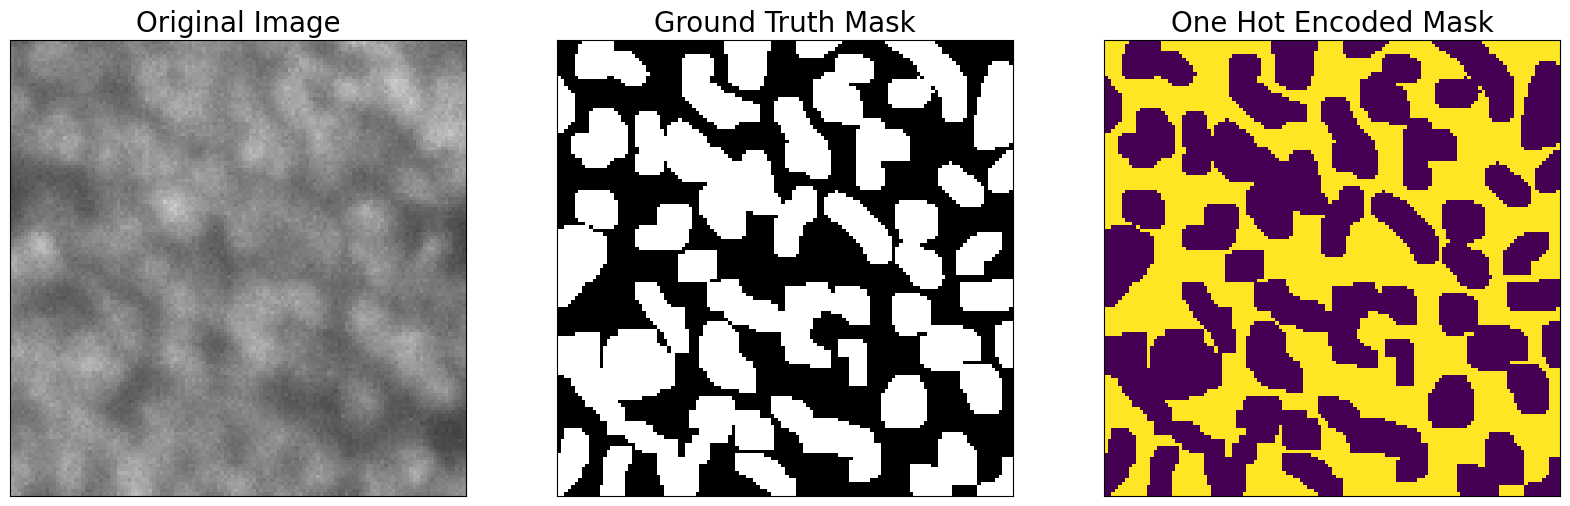

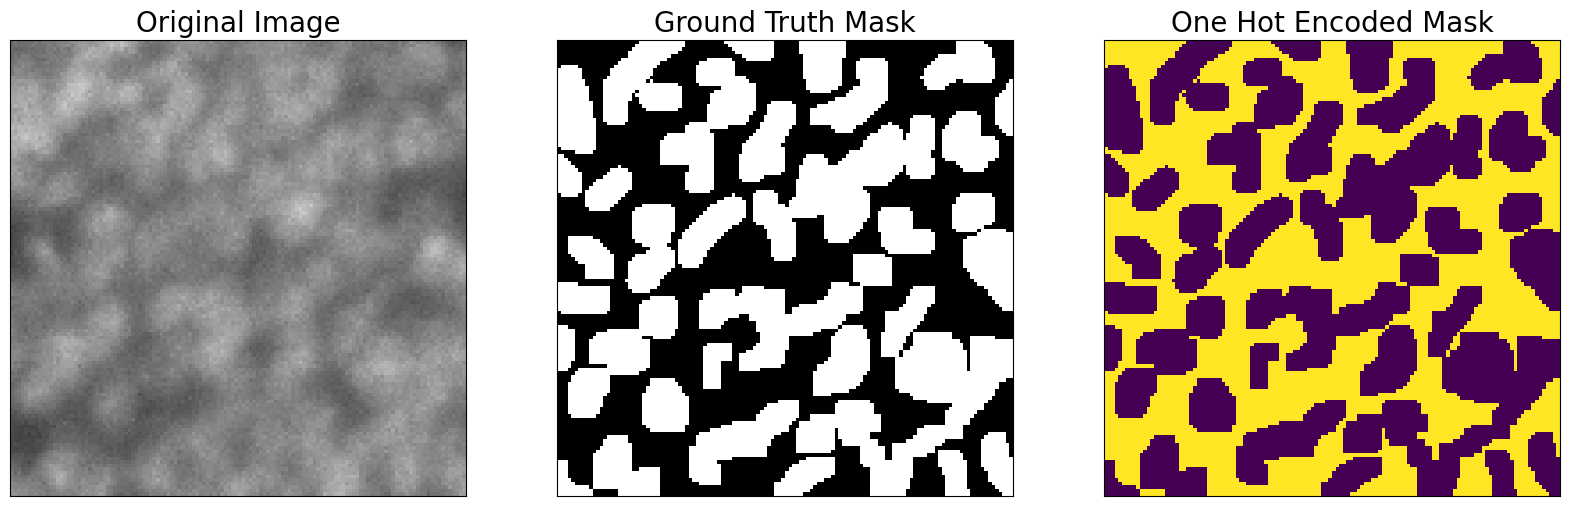

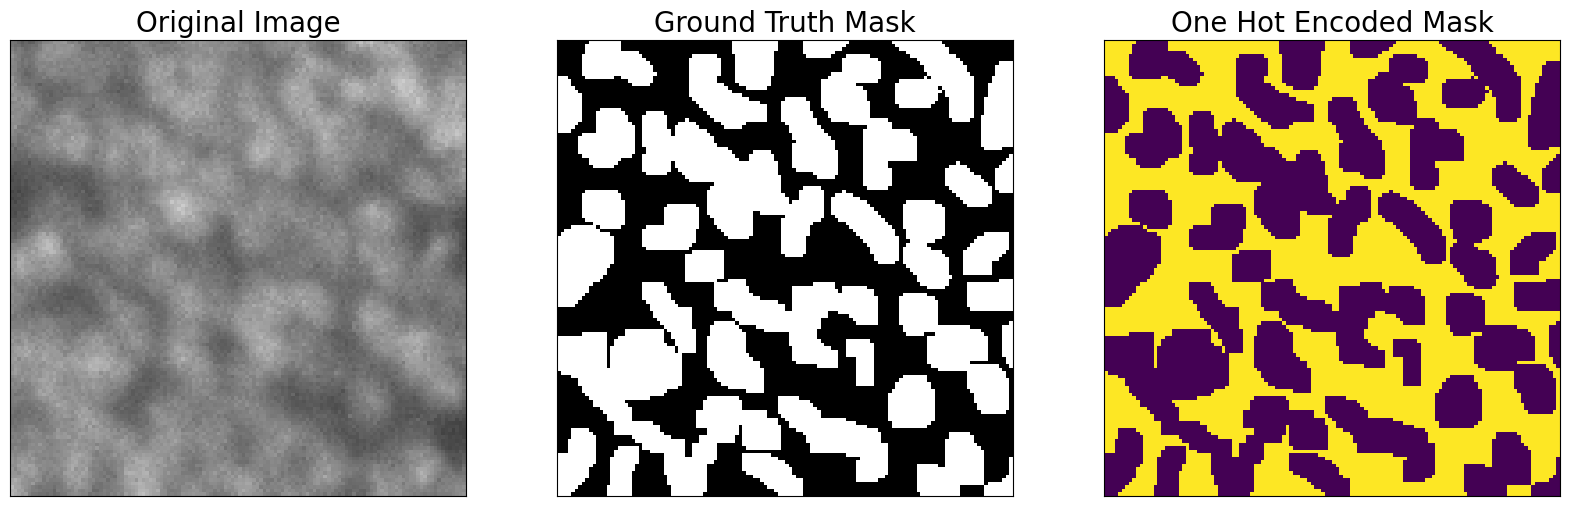

In [13]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

Create the attention U-net model from scratch.

In [14]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=2):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.last = nn.Sigmoid()


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x/255)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.last(d1)

        return d1


In [15]:
model = AttU_Net(img_ch=3, output_ch=2)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)


AttU_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
  

This the U-net model which is imported from the segmentation model pytorch package. We used two approaches here. If you want to implement the baseline model which is the non pretrained version of unet, you need to specify the encoder_weights = None, otherwise if youwant to use the pretrained model which is the advanced one, you need to set encoder_weights = 'imagenet'.

In [16]:
model = smp.Unet(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
    activation='sigmoid'
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = 'cpu'
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:16<00:00, 14.7MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [17]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)


Set the hyperparameters.

In [18]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
# DEVICE = 'cpu'

# define loss function
loss = smp.utils.losses.BCELoss()

# define metrics
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [19]:

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


Start the training for the DAPI cell.

In [20]:
if TRAINING:

    valid_loss = 1e7
    train_logs_list, valid_logs_list = [], []
    patience = 0
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if valid_loss > valid_logs['bce_loss']:
            valid_loss = valid_logs['bce_loss']
            torch.save(model, './best_model_FCN.pth')
            print('Model saved!')
            patience=0
            print(patience)
        else:
            patience = patience + 1
            print(patience)
            if patience>3:
                break
            else:
                continue



Epoch: 0
valid: 100%|██████████| 17/17 [00:10<00:00,  1.55it/s, bce_loss - 0.6159, fscore - 0.7293, iou_score - 0.5904, precision - 0.6873, recall - 0.7809]
Model saved!
0

Epoch: 1
valid: 100%|██████████| 17/17 [00:00<00:00, 27.71it/s, bce_loss - 0.6142, fscore - 0.7548, iou_score - 0.6299, precision - 0.7288, recall - 0.7858]
Model saved!
0

Epoch: 2
valid: 100%|██████████| 17/17 [00:00<00:00, 28.62it/s, bce_loss - 0.8377, fscore - 0.6553, iou_score - 0.5487, precision - 0.6448, recall - 0.6681]
1

Epoch: 3
valid: 100%|██████████| 17/17 [00:00<00:00, 25.44it/s, bce_loss - 0.5392, fscore - 0.7781, iou_score - 0.6733, precision - 0.7604, recall - 0.7981]
Model saved!
0

Epoch: 4
valid: 100%|██████████| 17/17 [00:00<00:00, 28.25it/s, bce_loss - 0.5388, fscore - 0.7866, iou_score - 0.6925, precision - 0.7702, recall - 0.8053]
Model saved!
0

Epoch: 5
valid: 100%|██████████| 17/17 [00:00<00:00, 28.55it/s, bce_loss - 0.5078, fscore - 0.8106, iou_score - 0.7136, precision - 0.785, recall -

In [21]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load best saved model checkpoint from the current run
if os.path.exists('./best_model_FCN.pth'):
    best_model = torch.load('./best_model_FCN.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model_FCN.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model_FCN.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


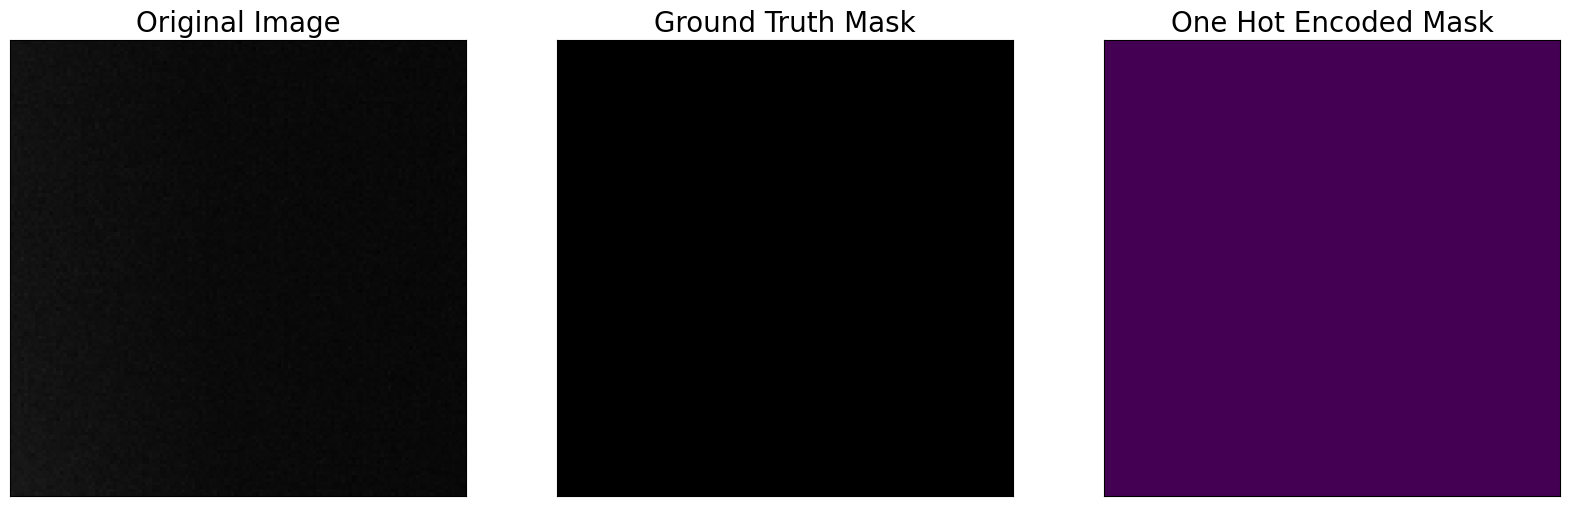

In [22]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 256*256 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

Prepare the testing images according to the data pipeline.

In [23]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [24]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

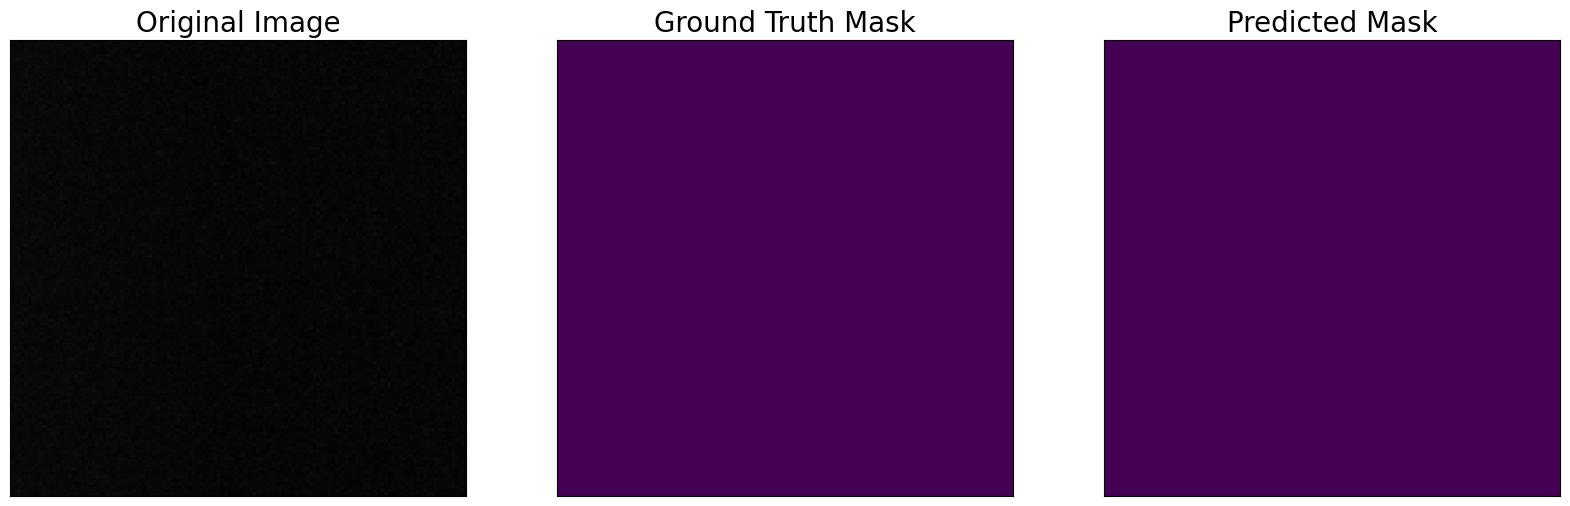

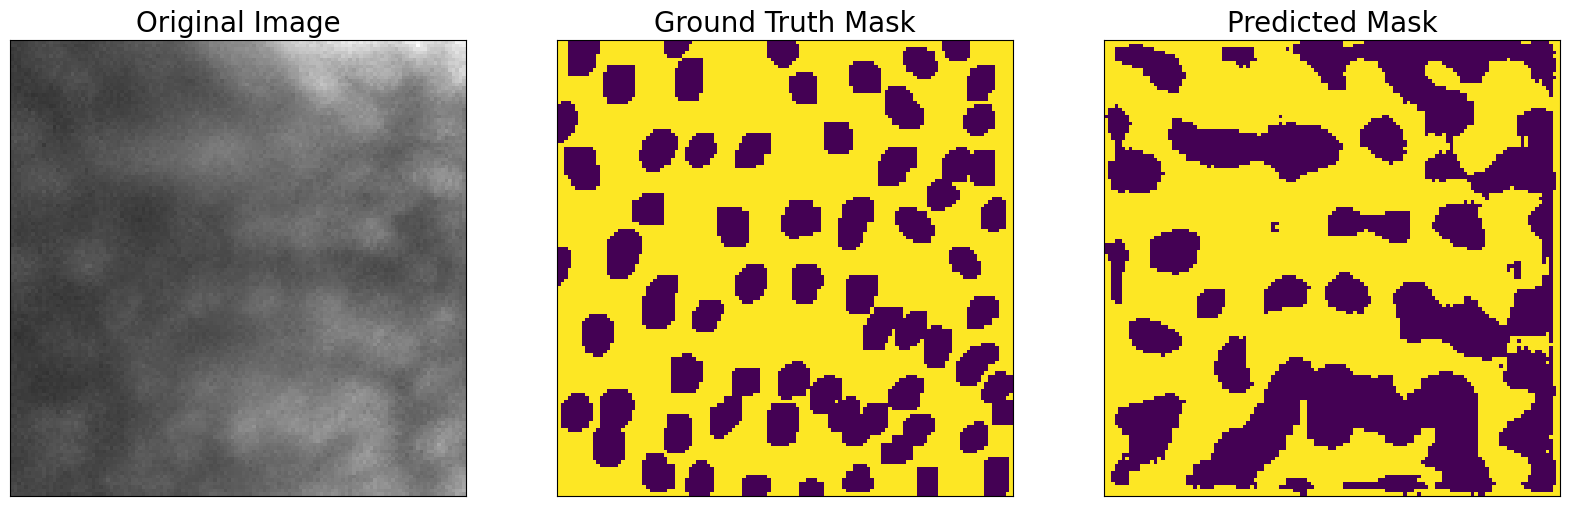

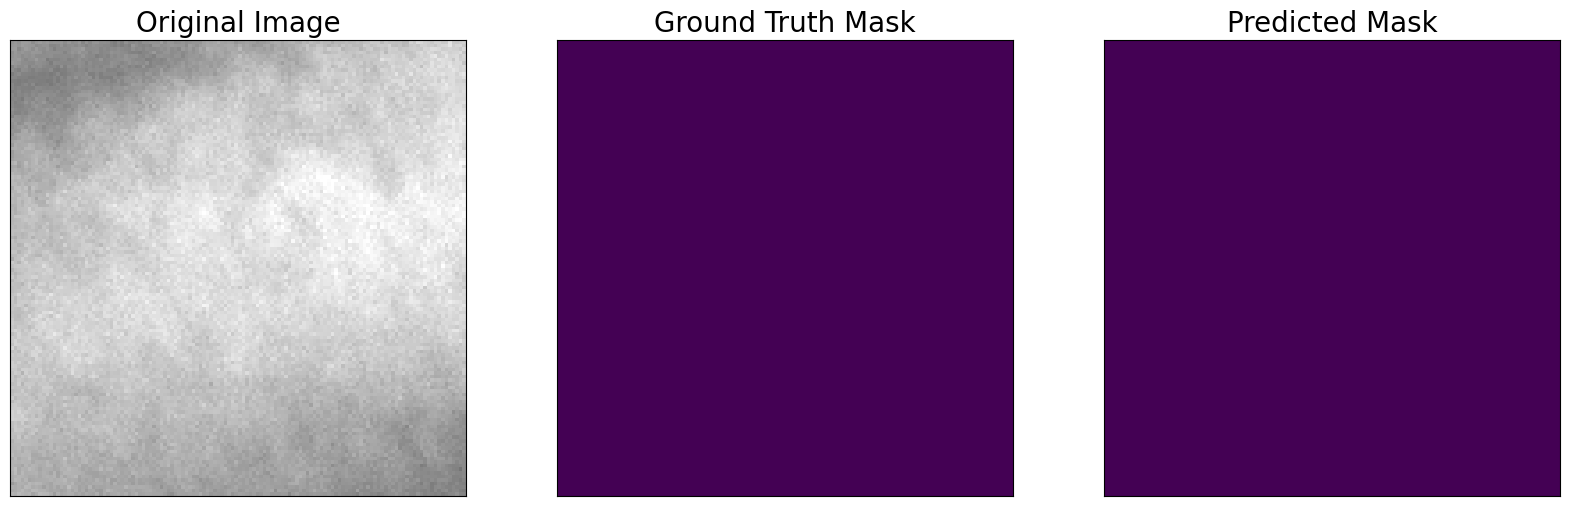

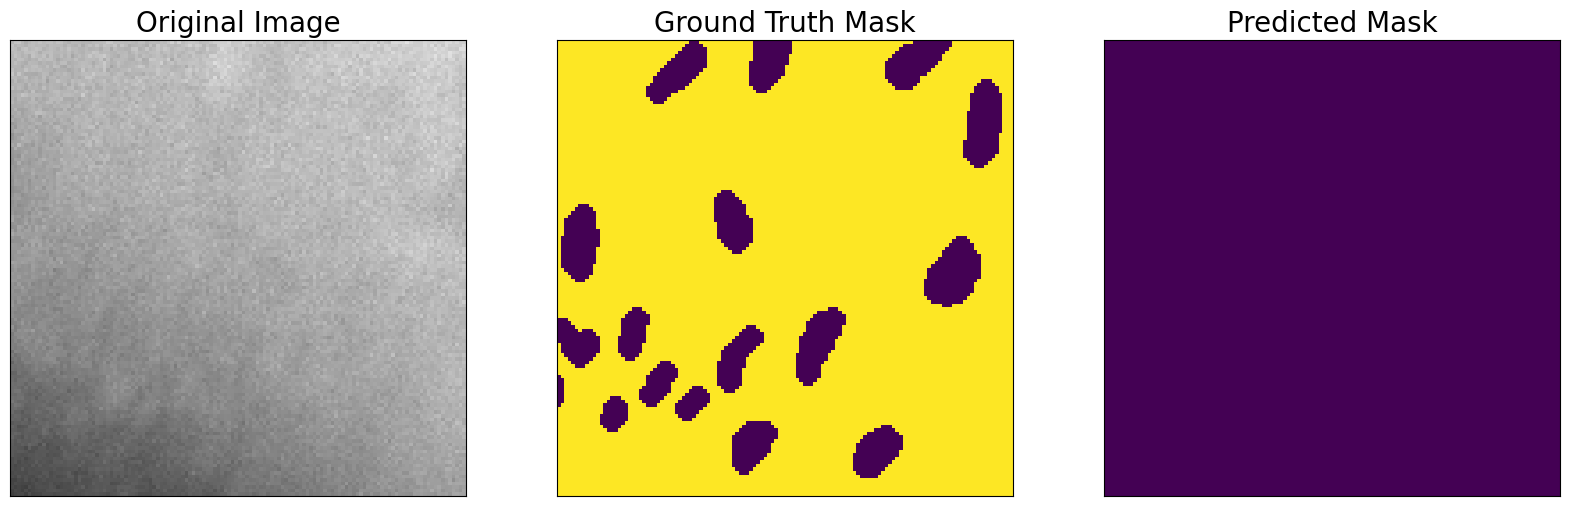

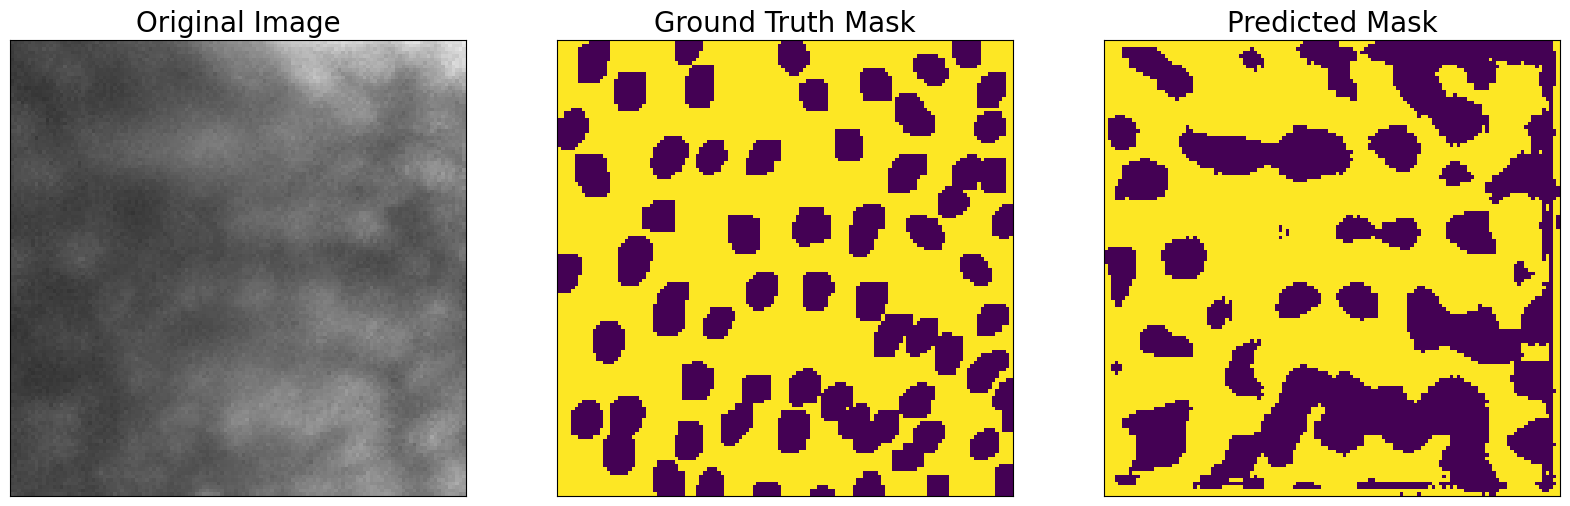

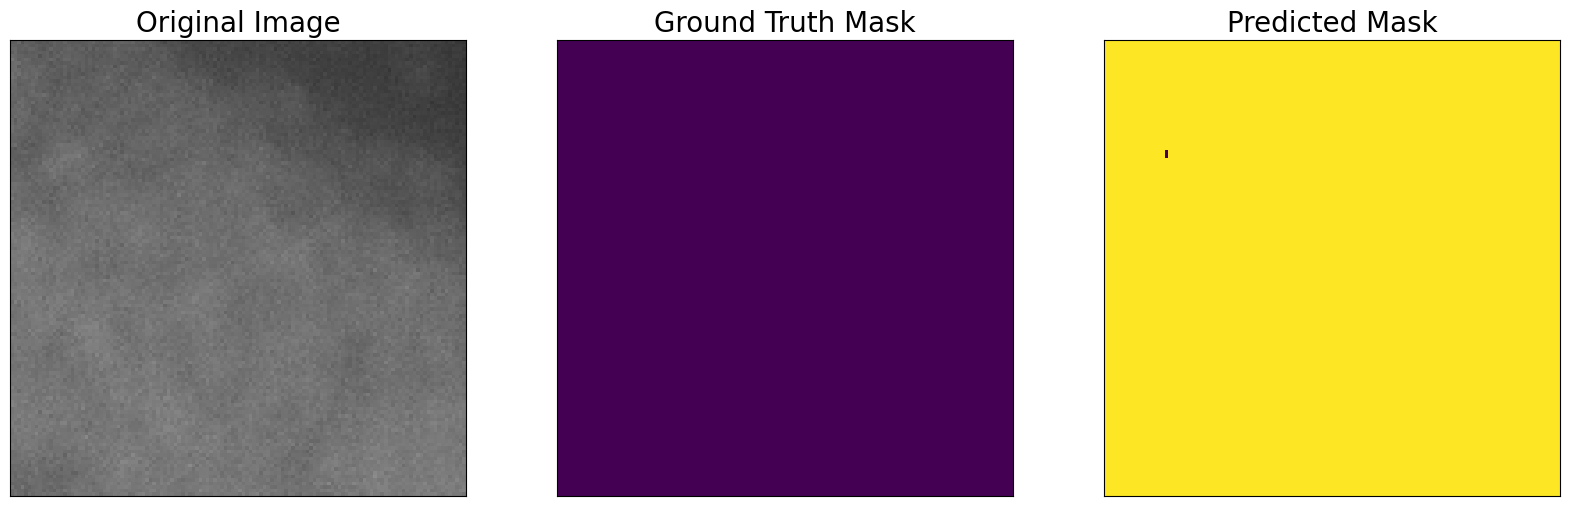

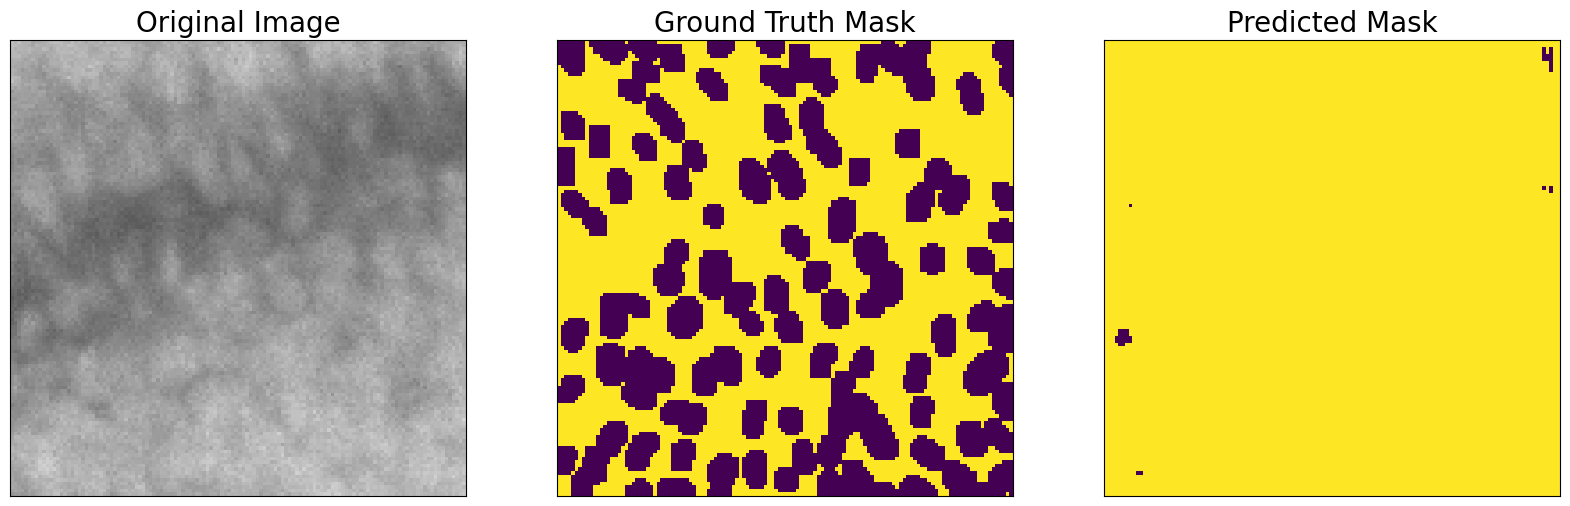

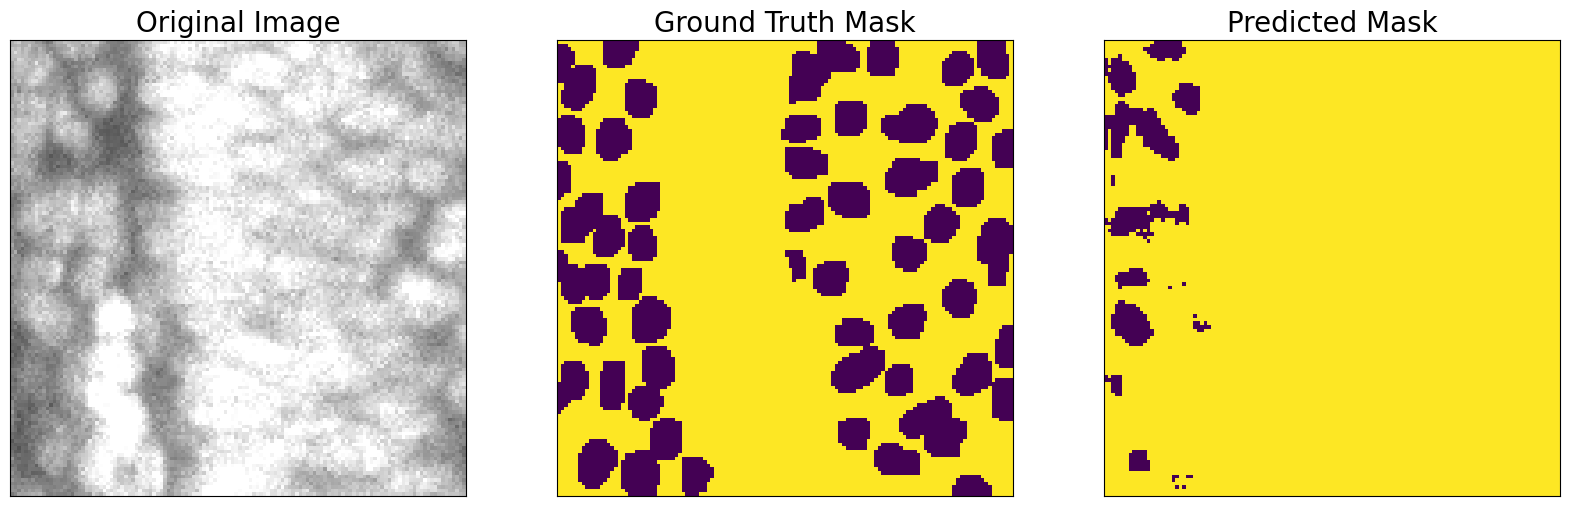

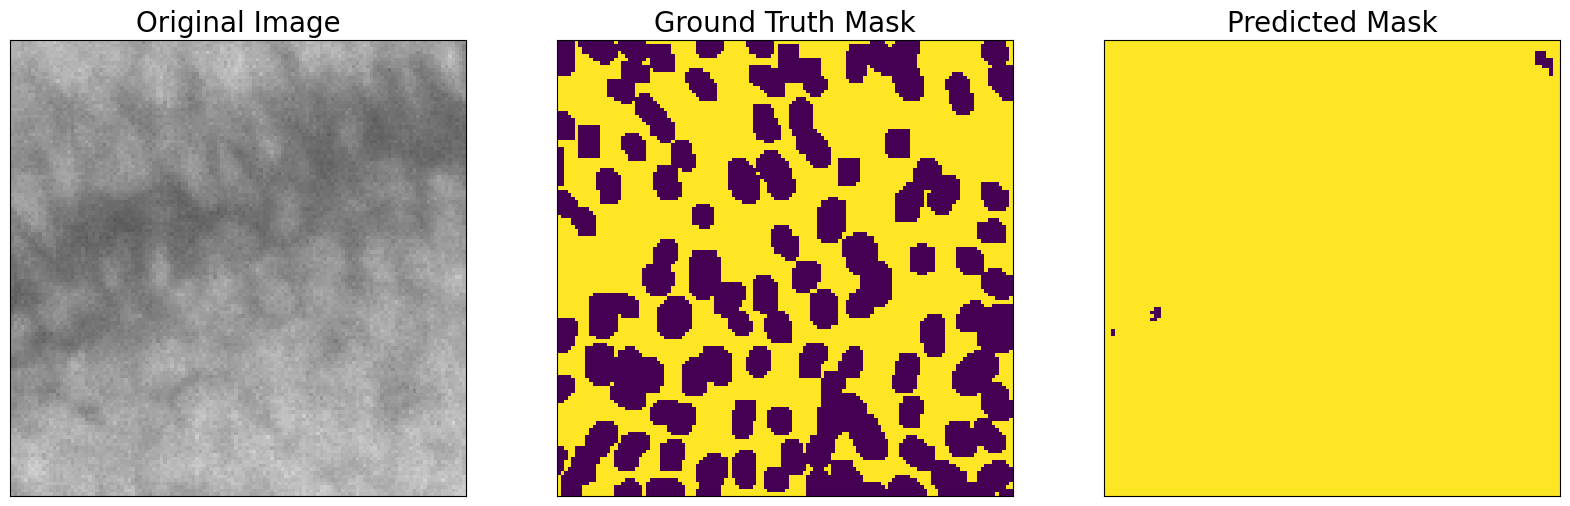

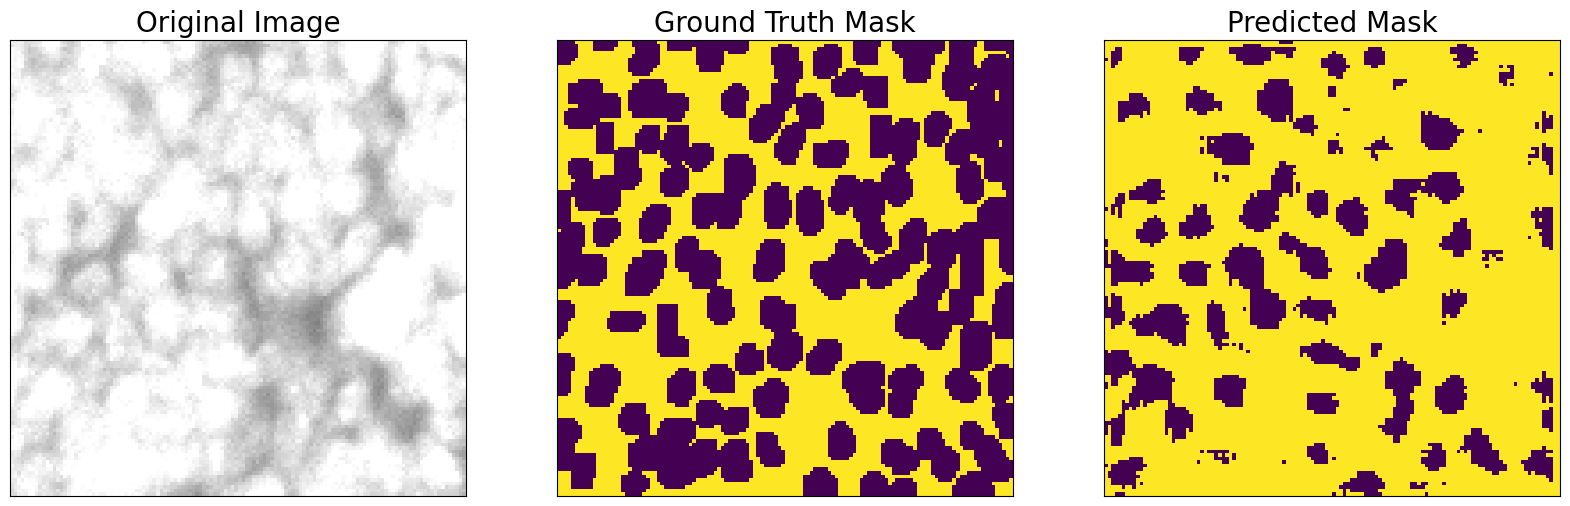

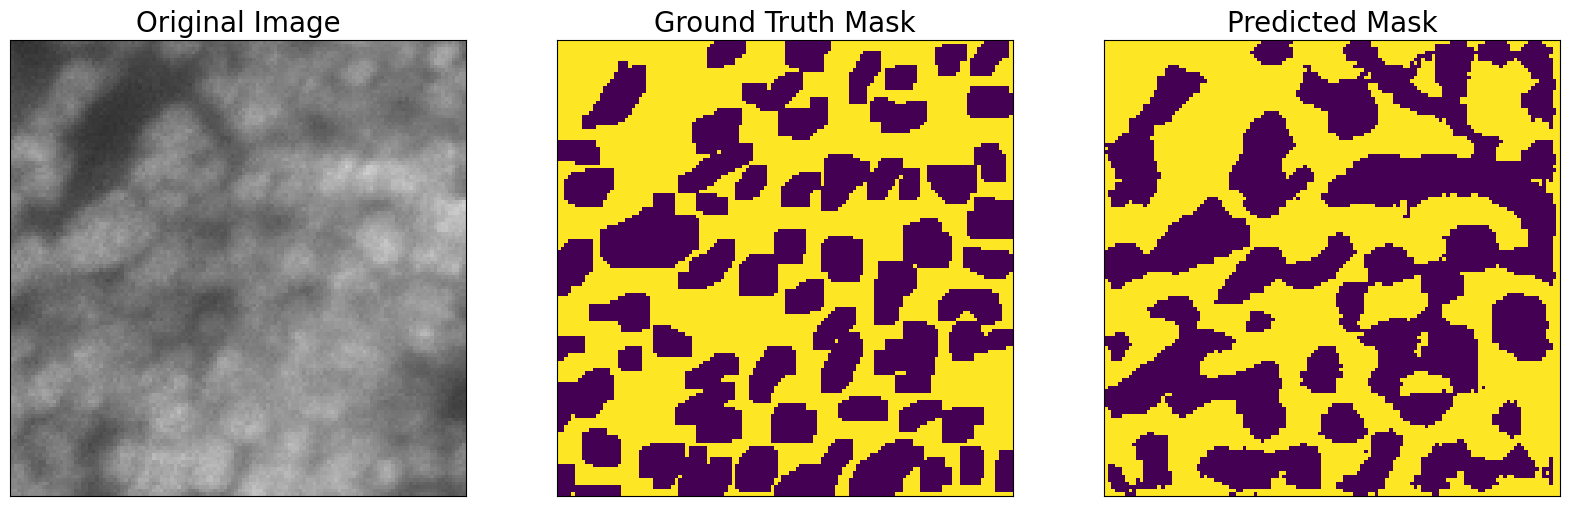

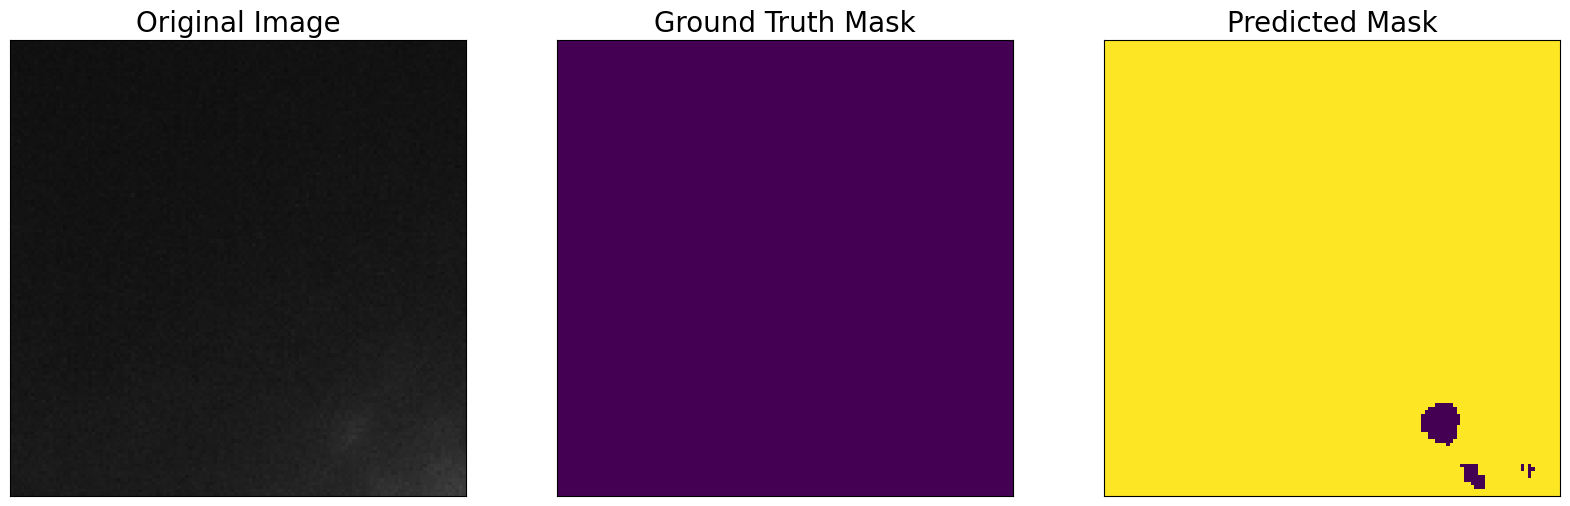

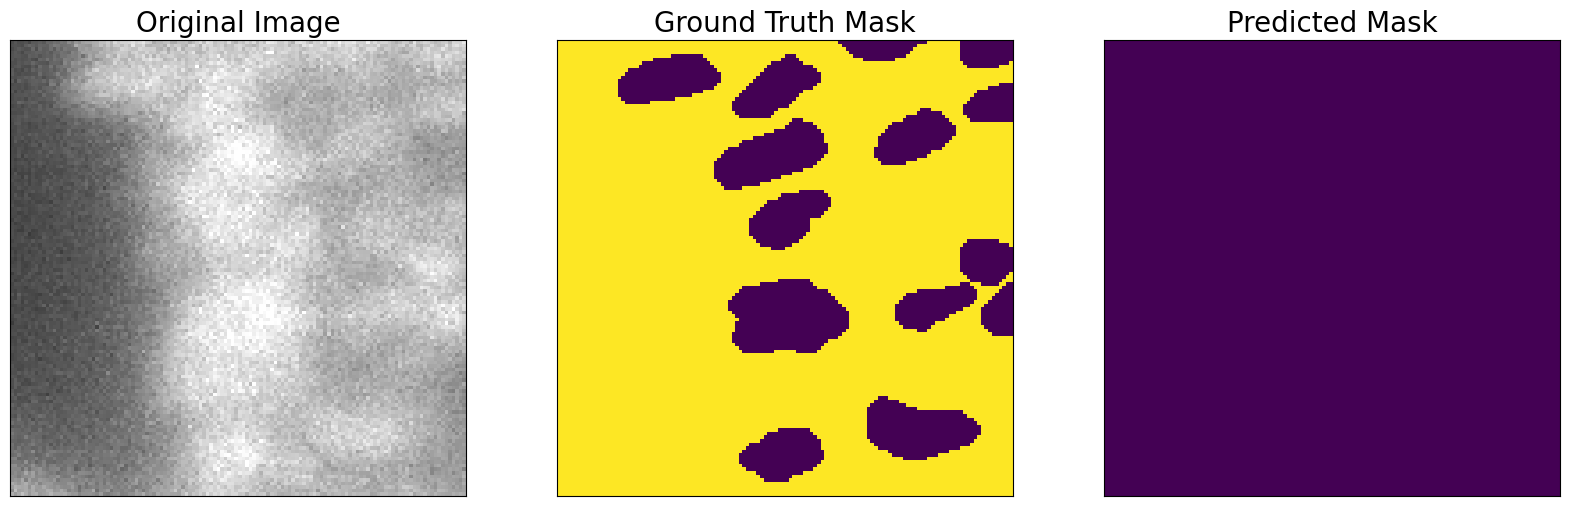

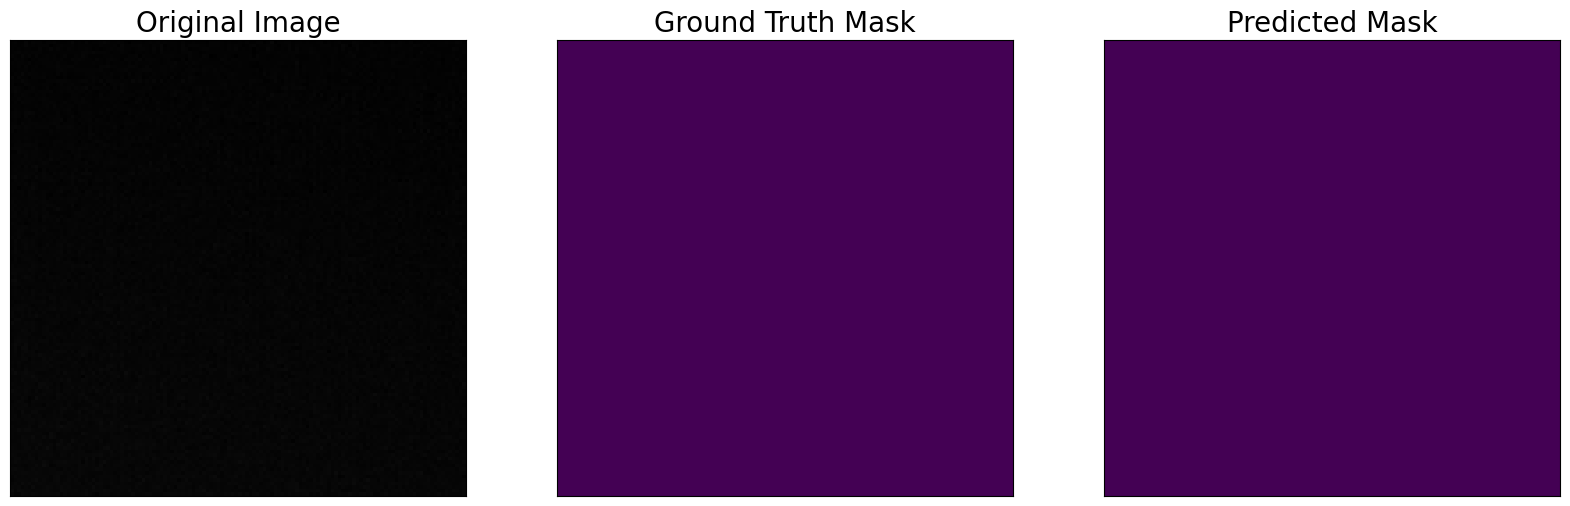

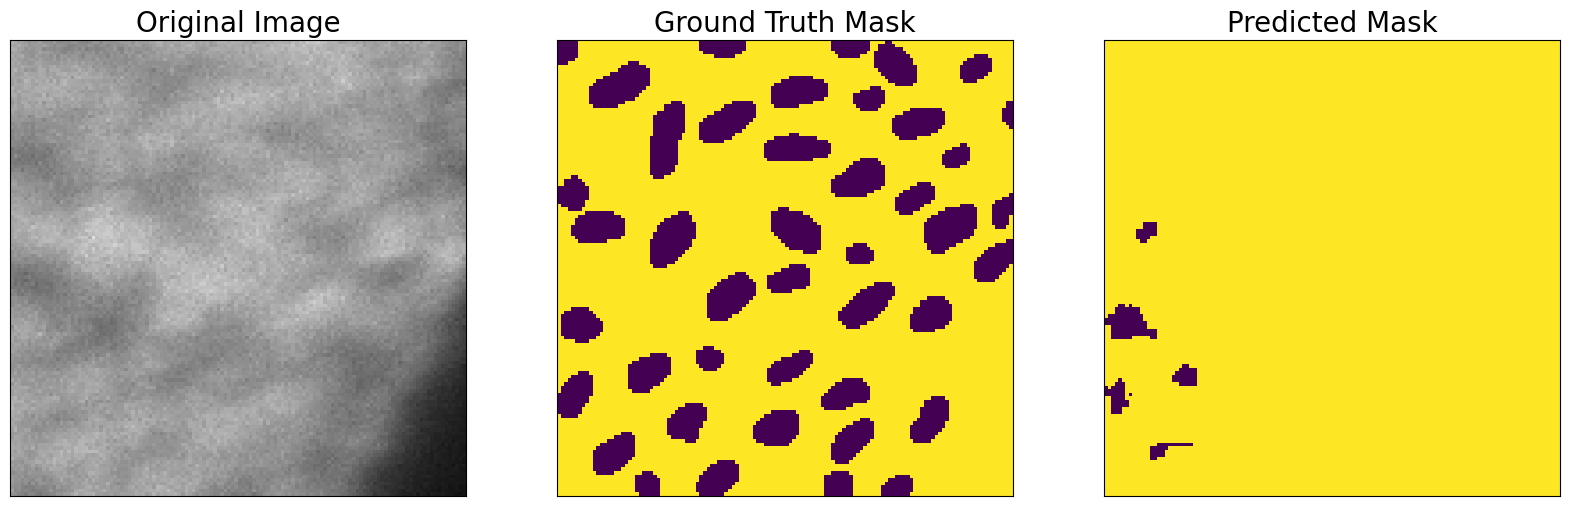

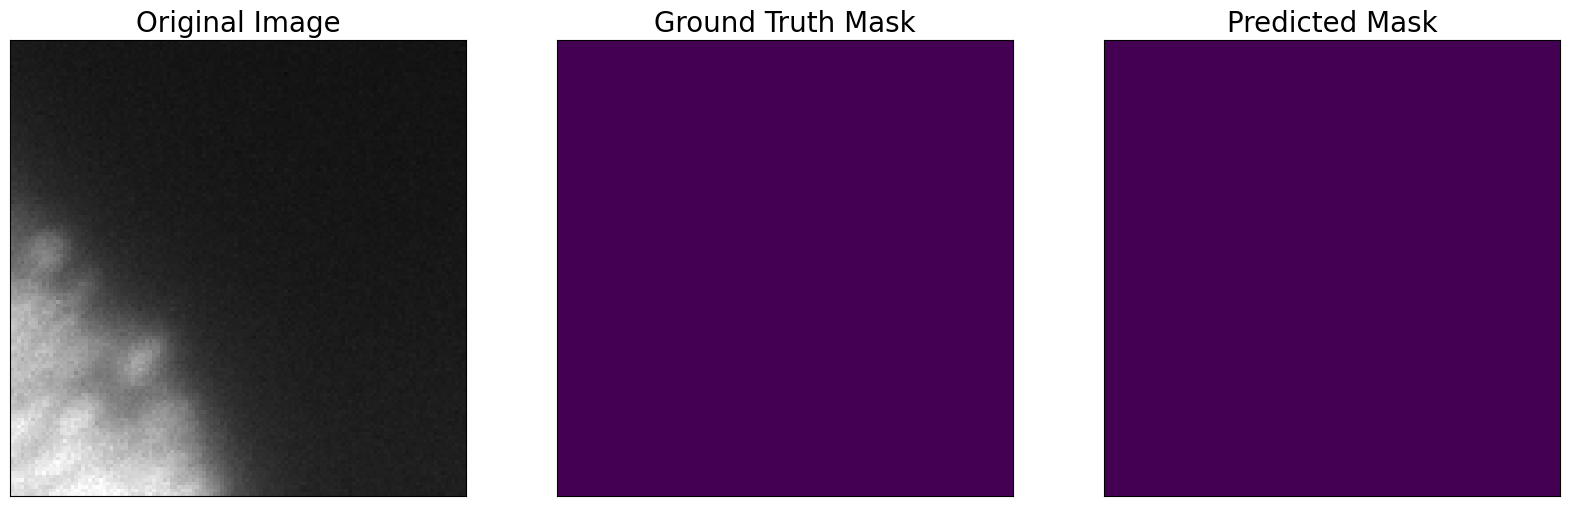

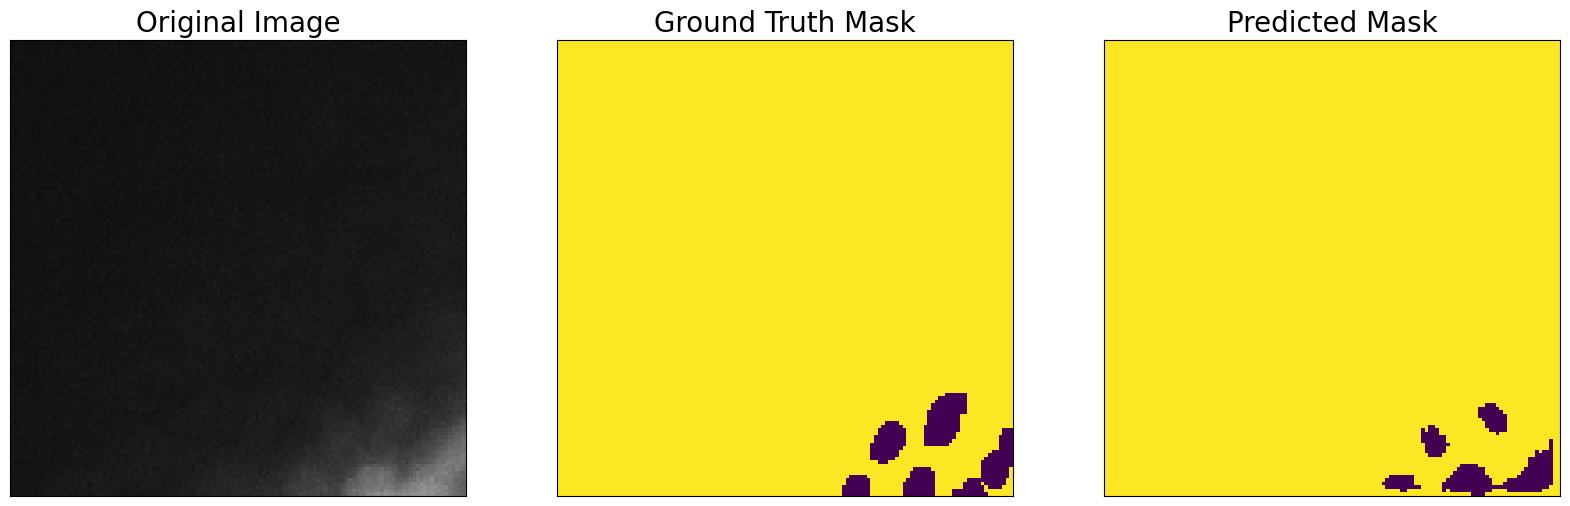

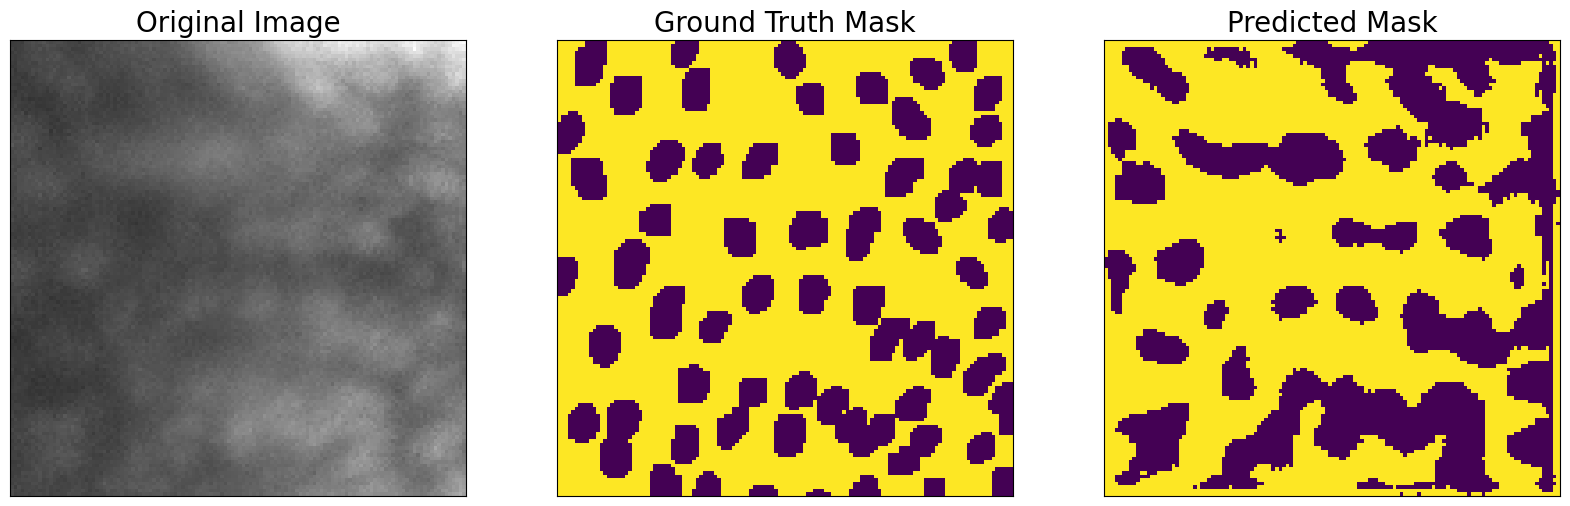

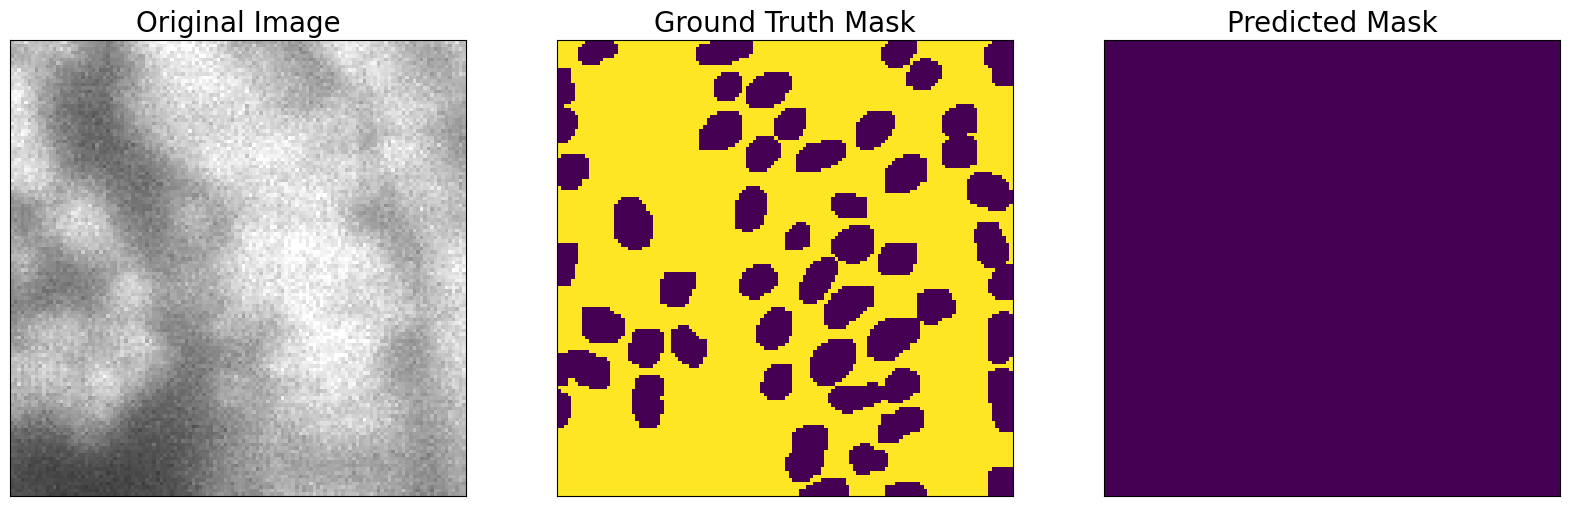

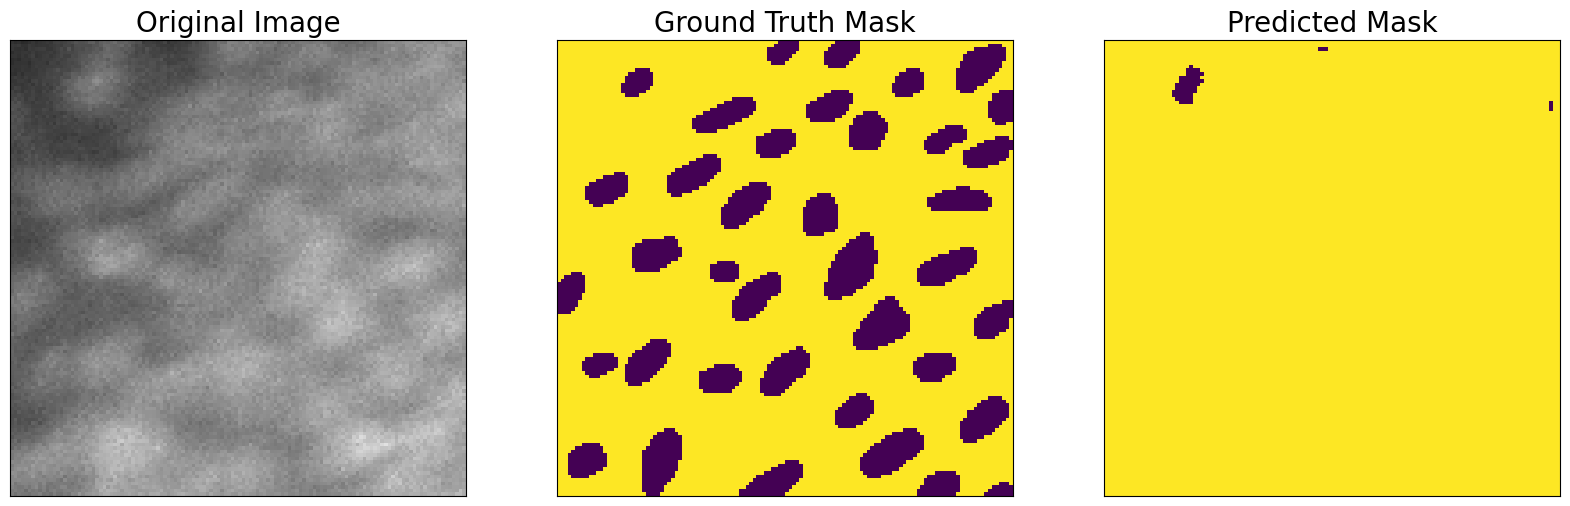

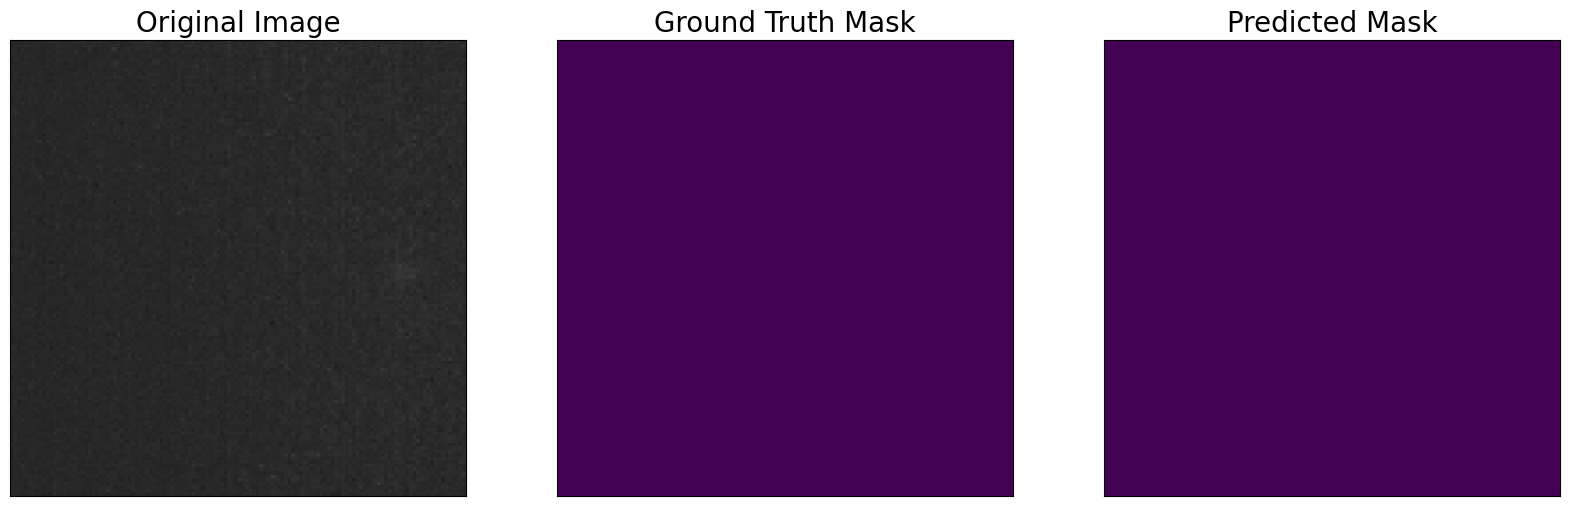

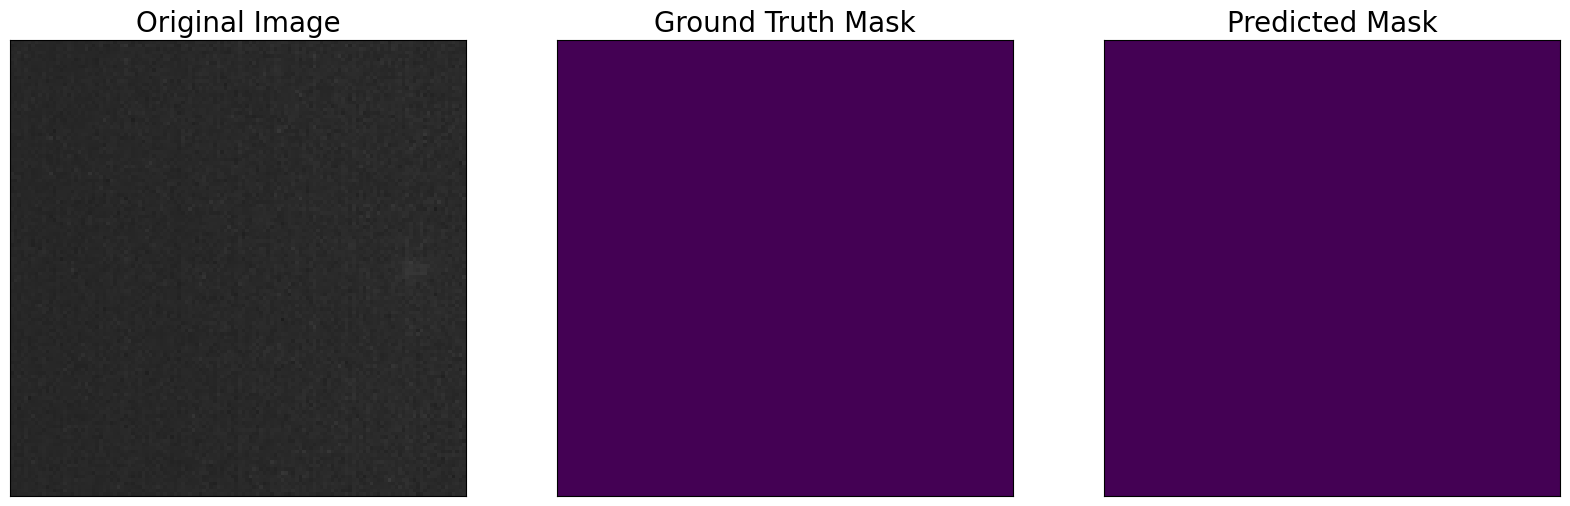

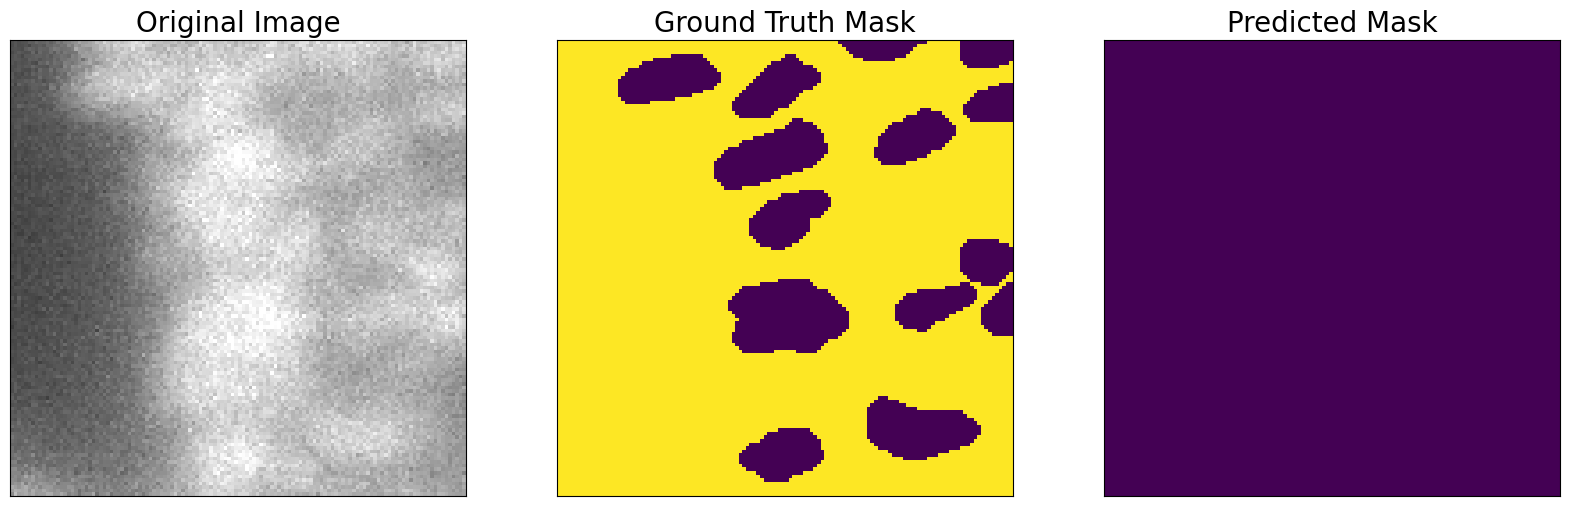

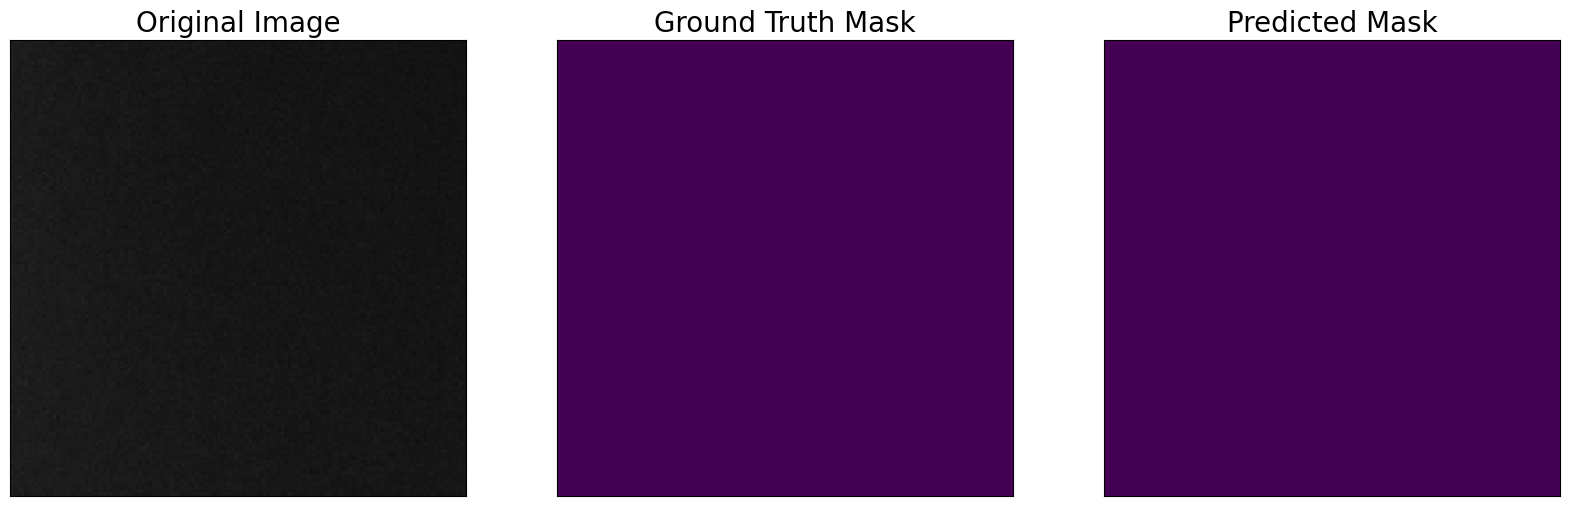

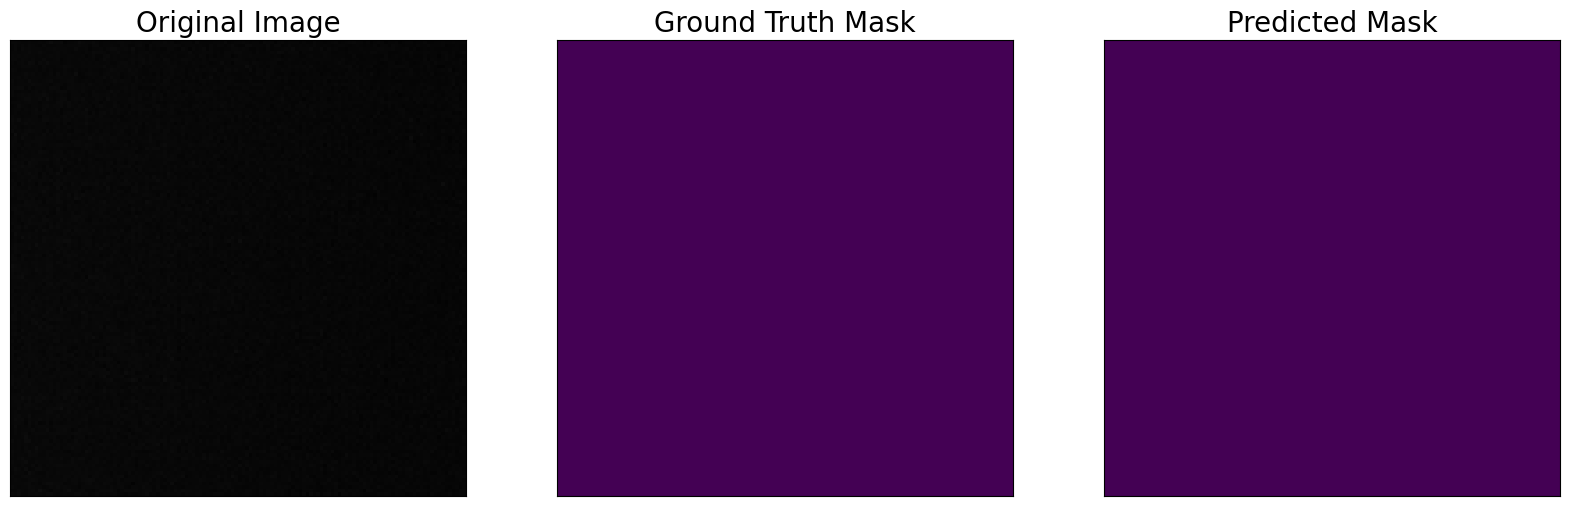

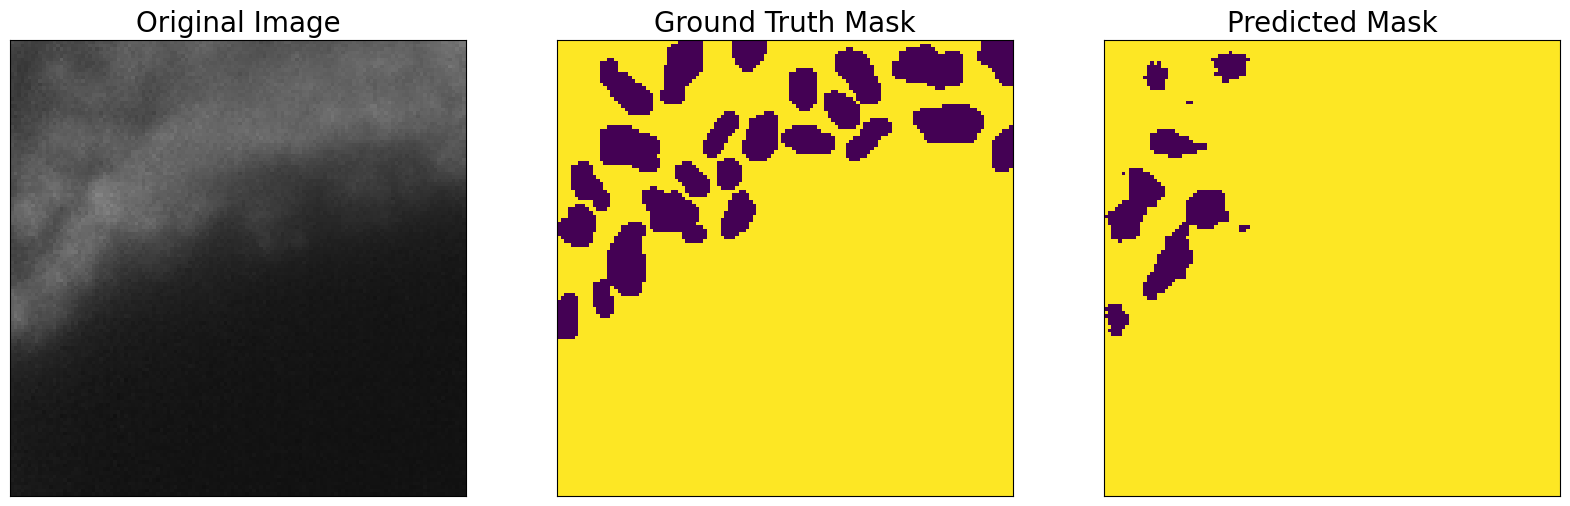

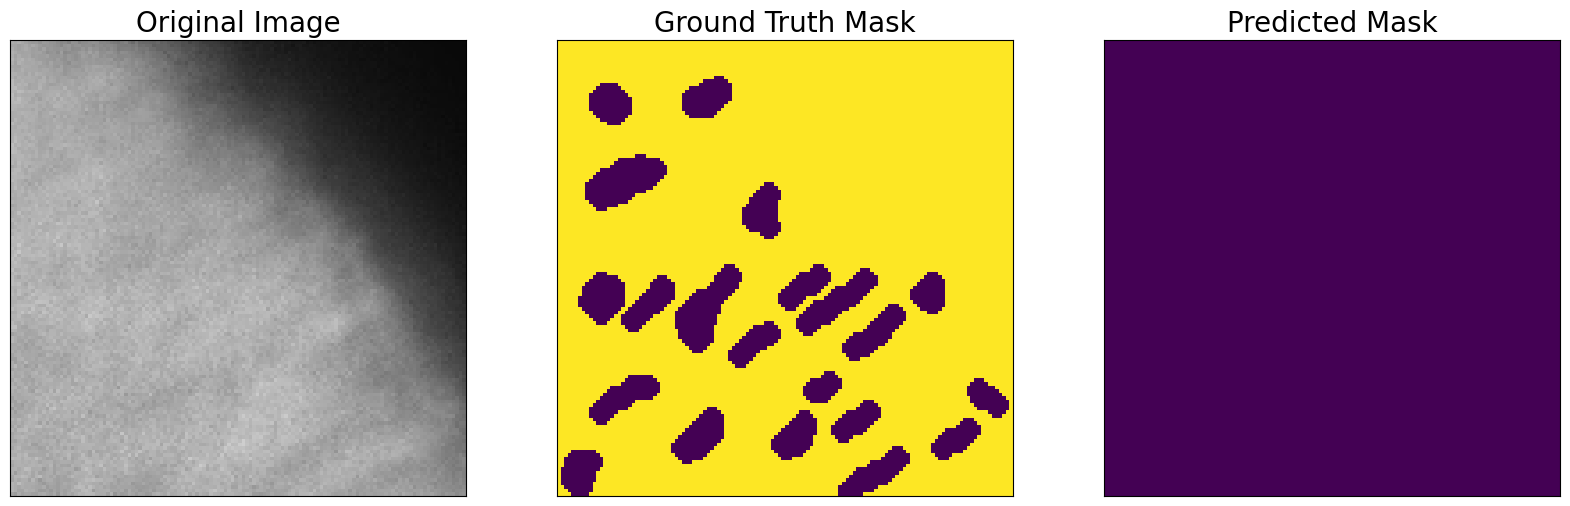

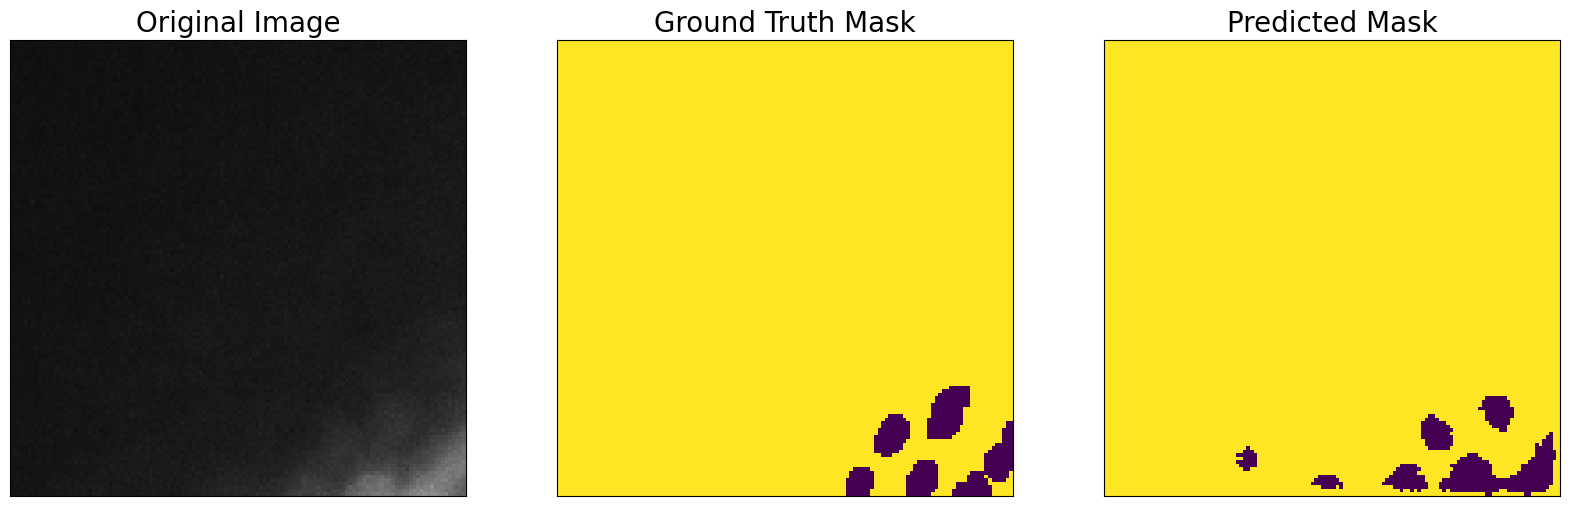

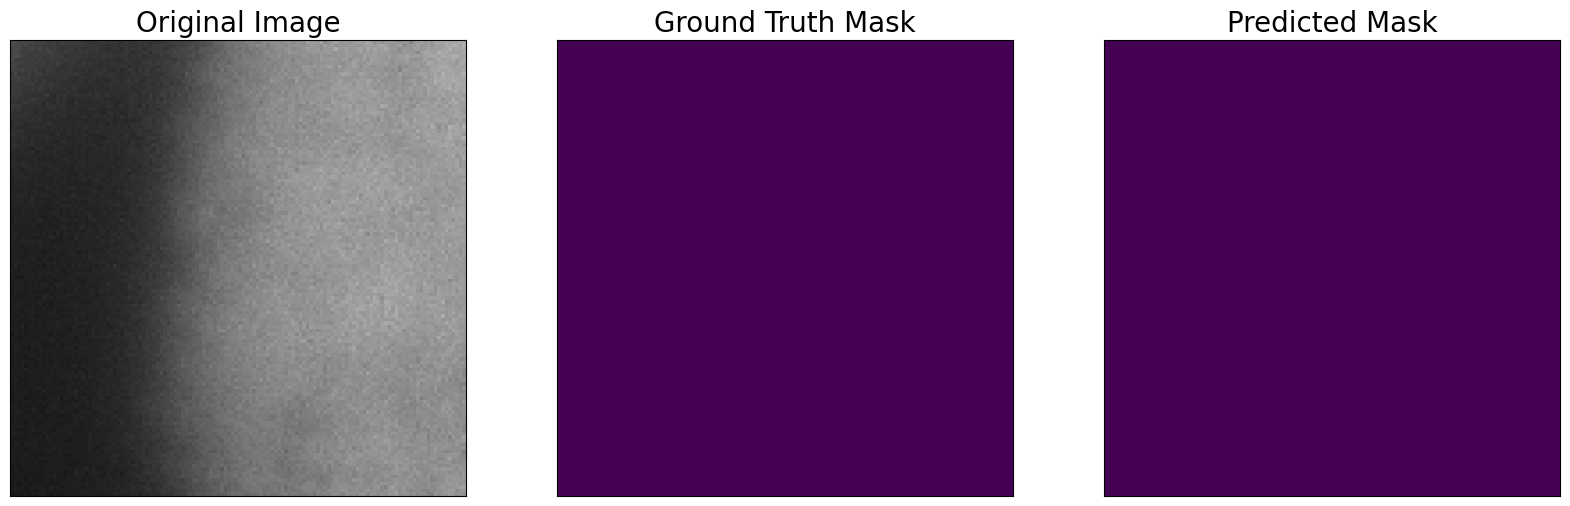

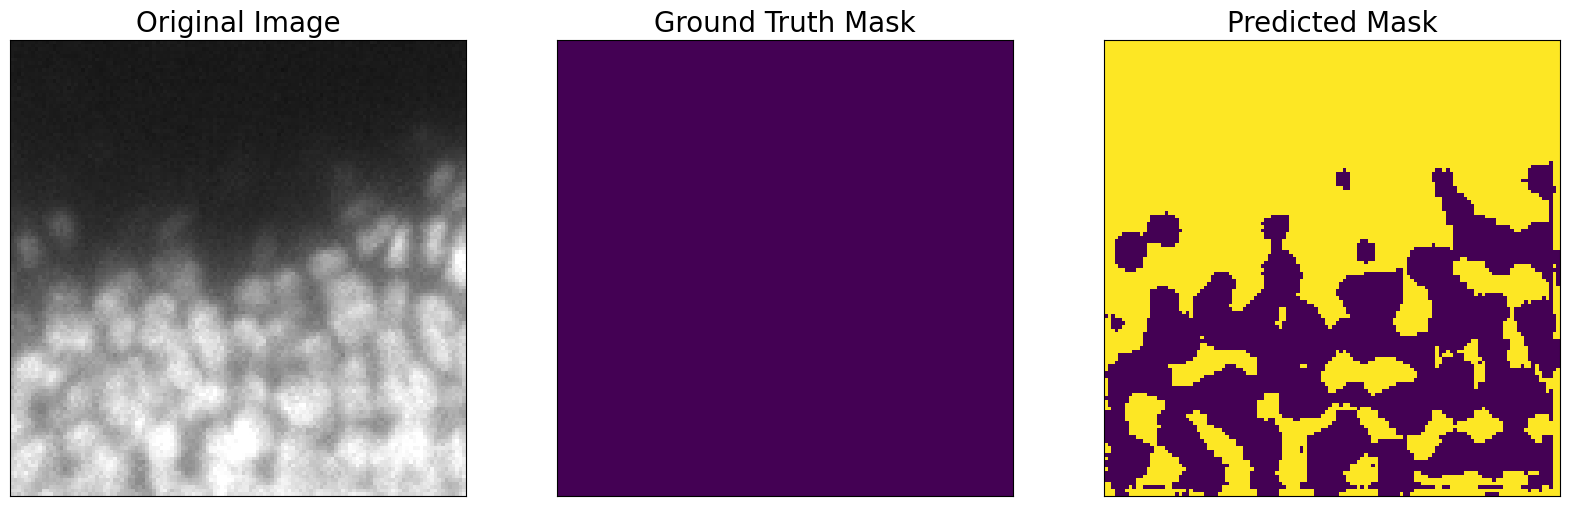

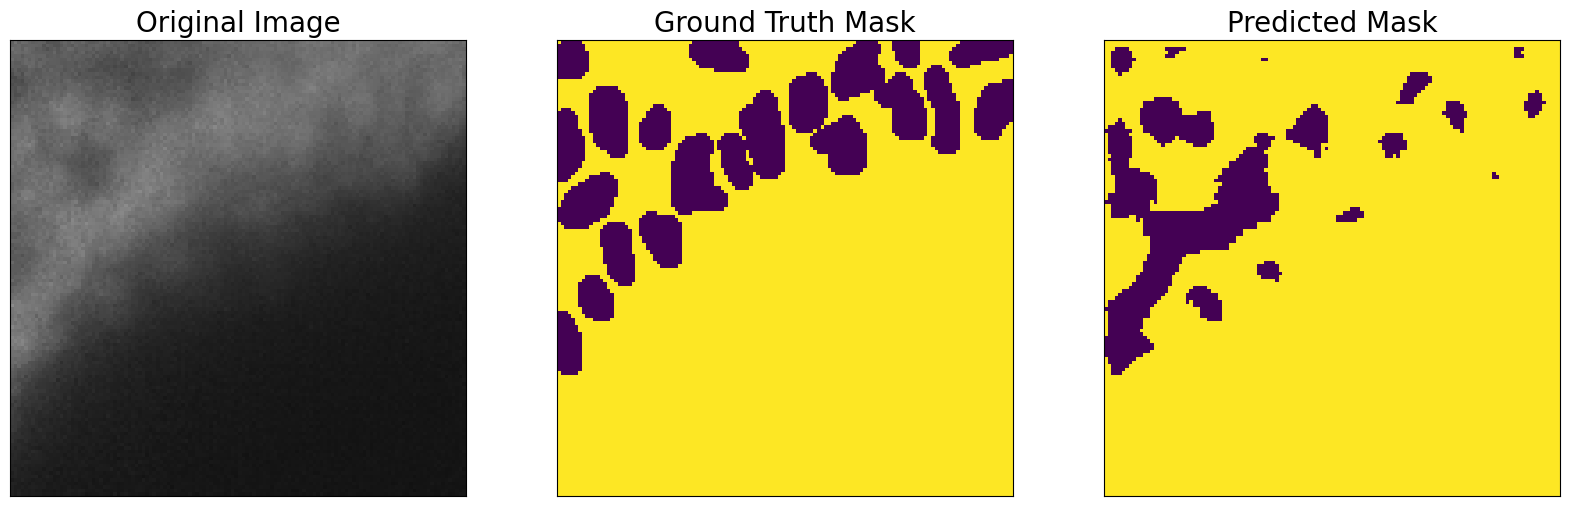

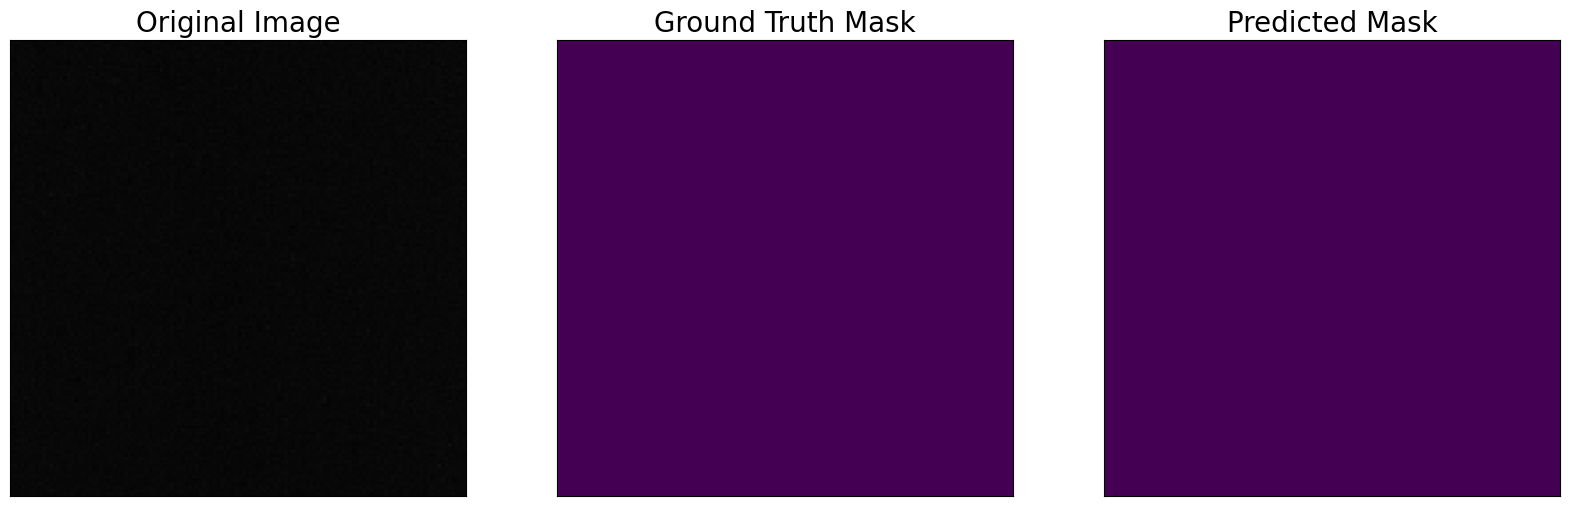

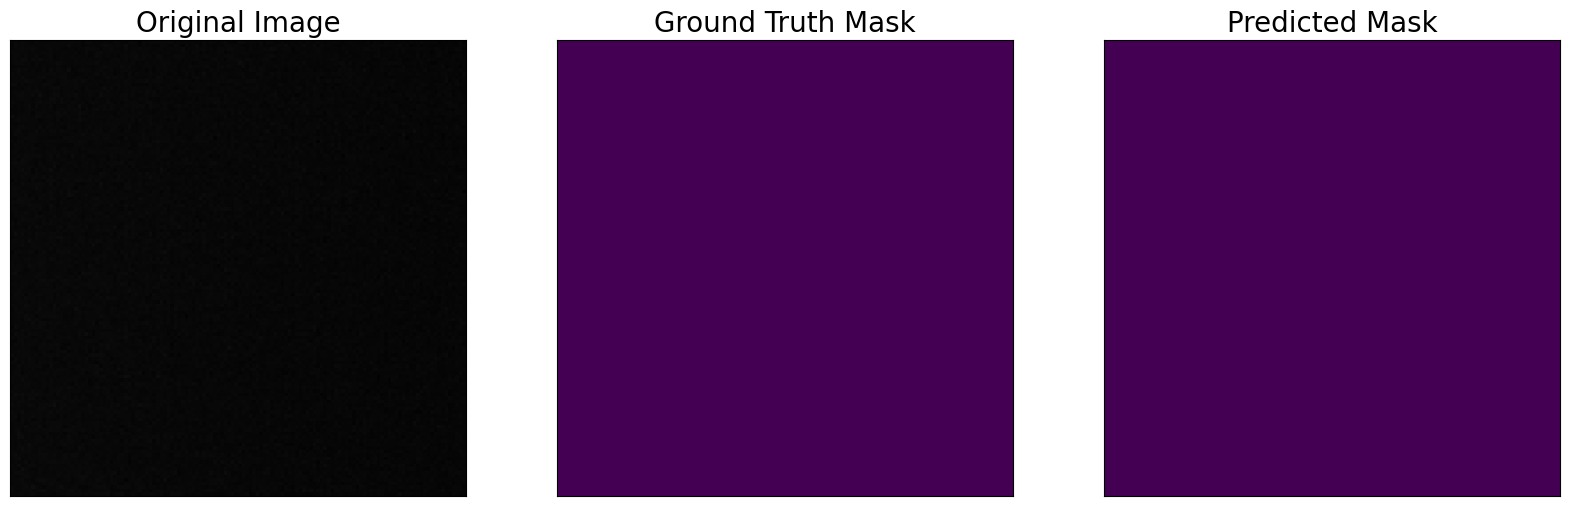

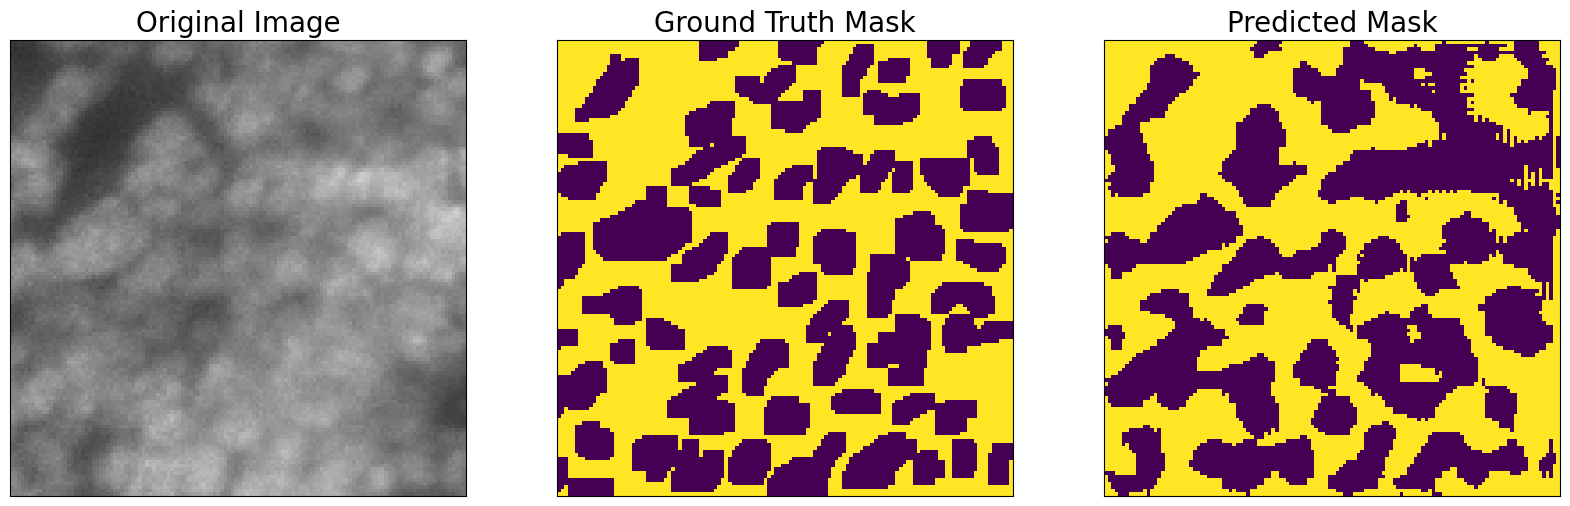

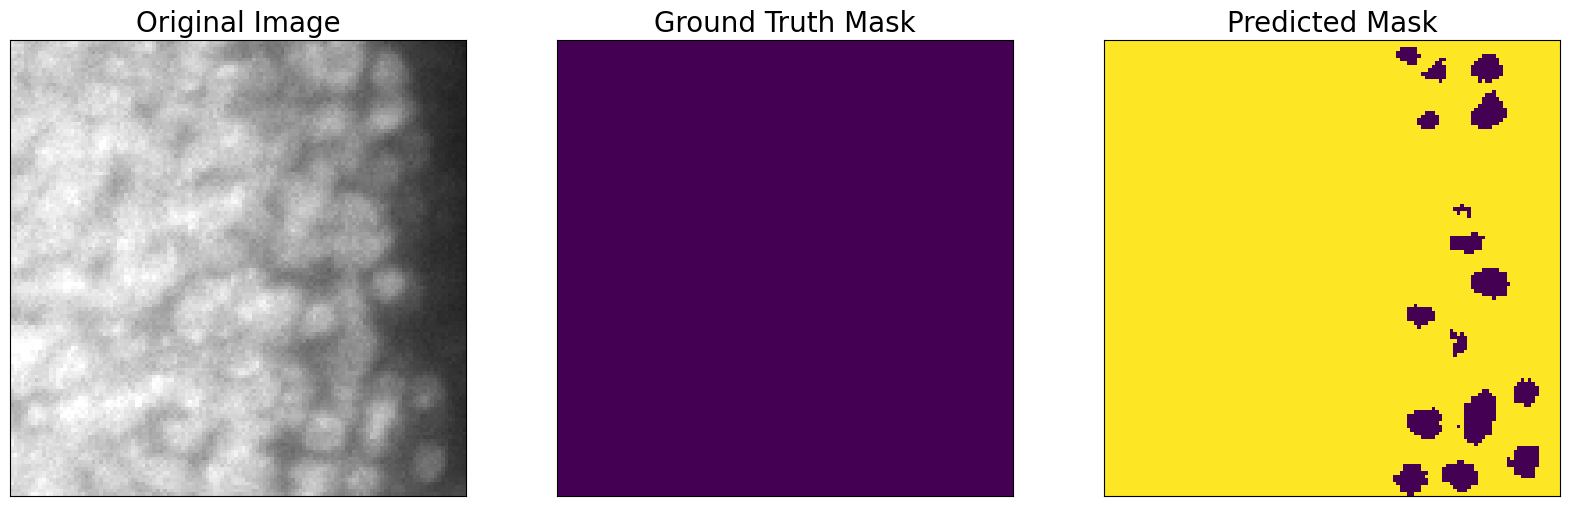

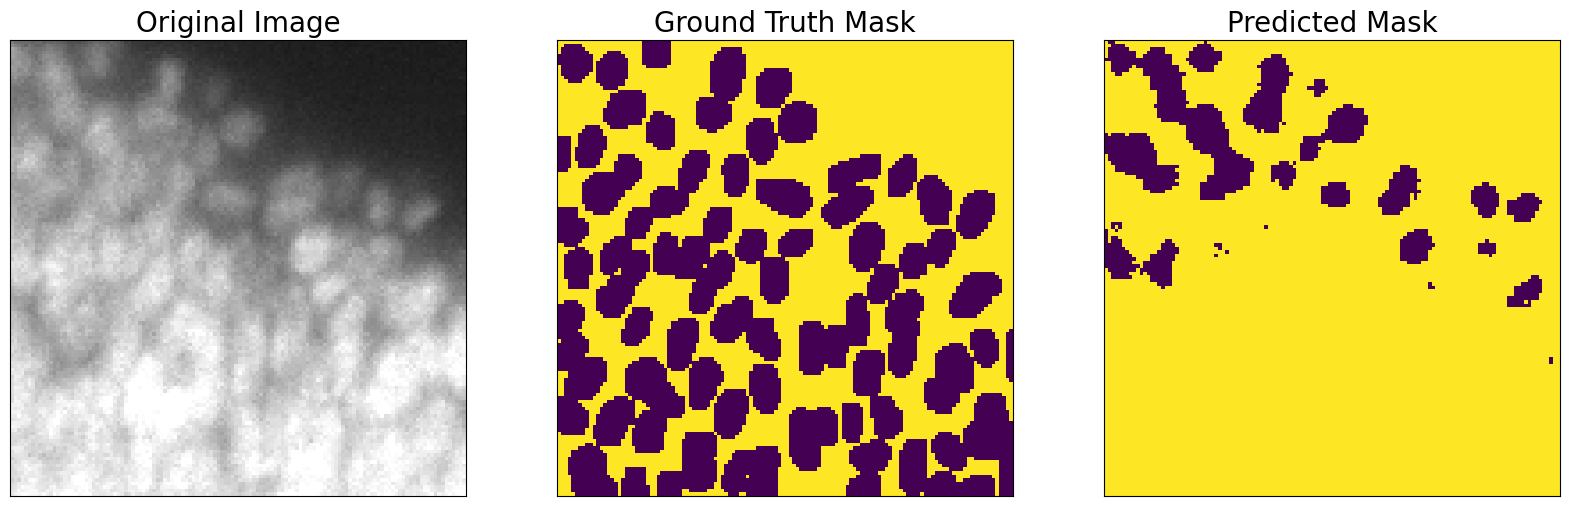

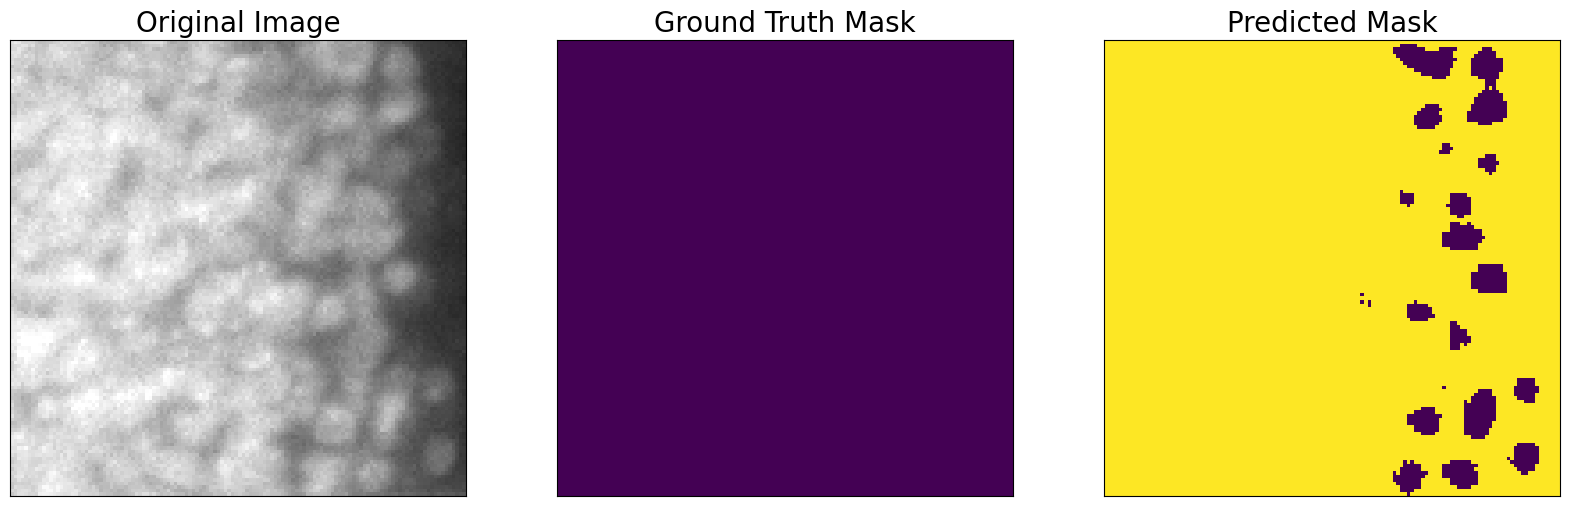

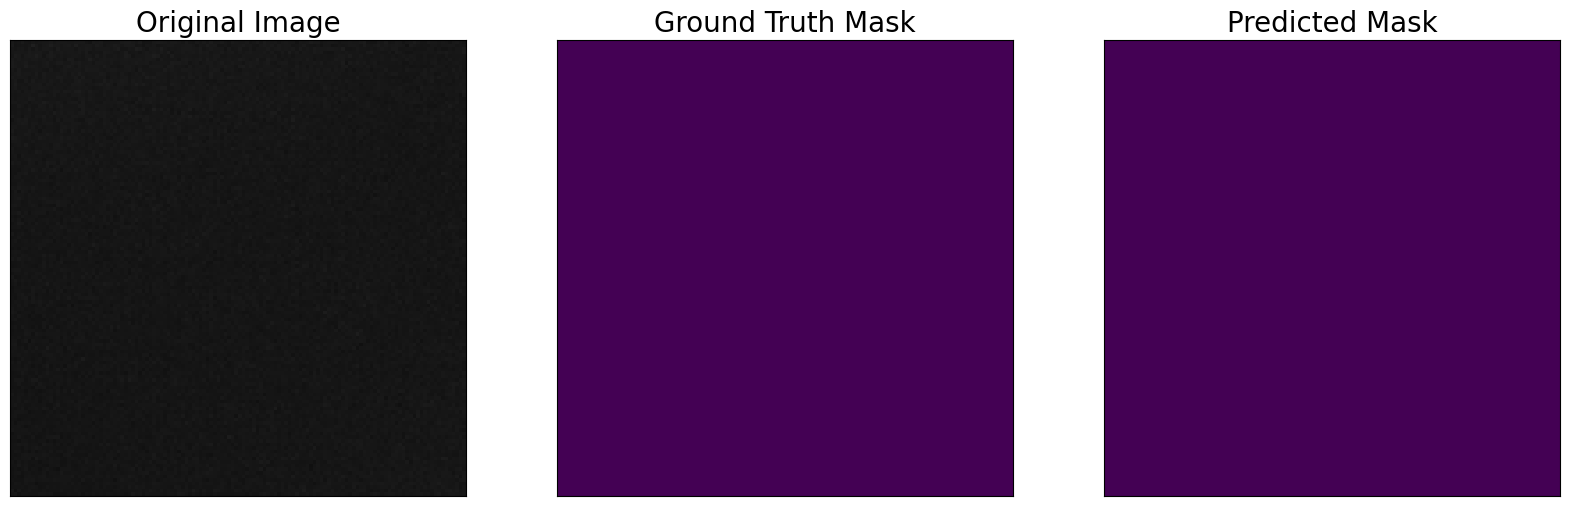

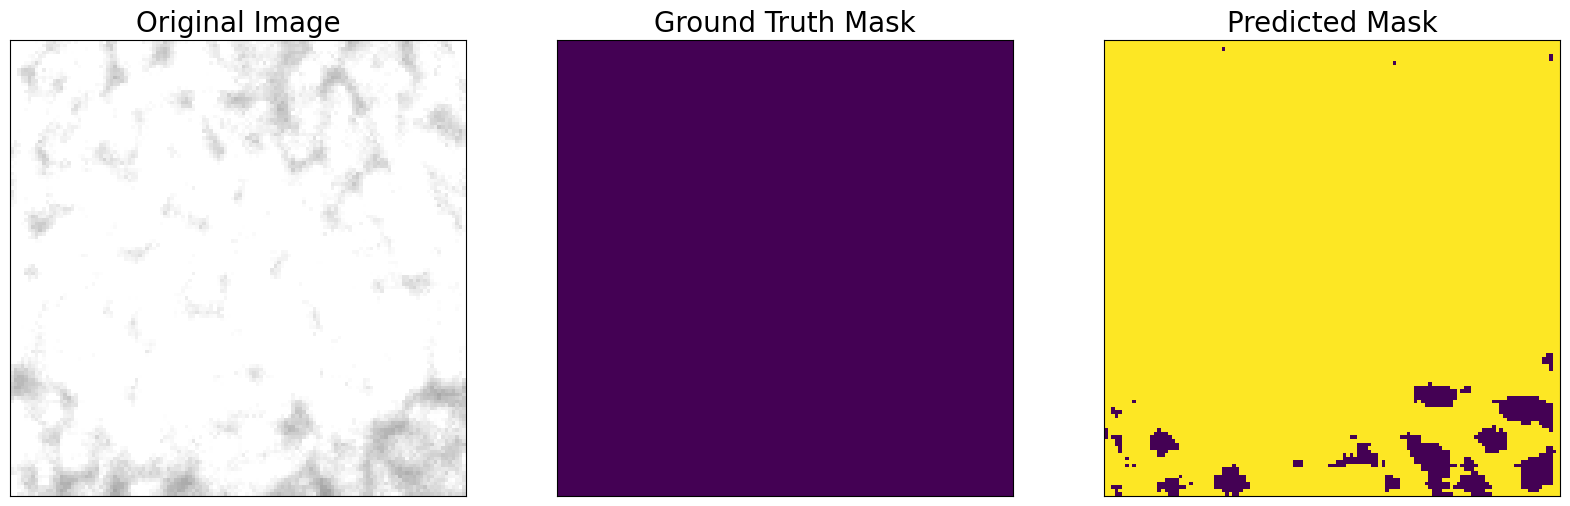

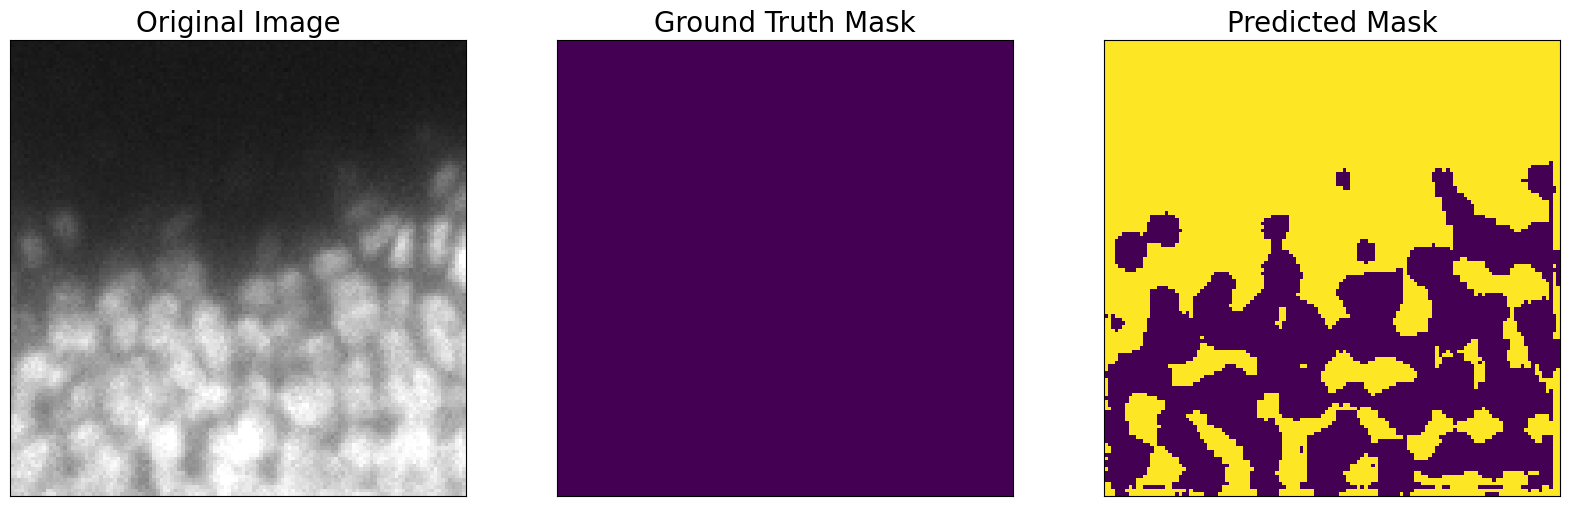

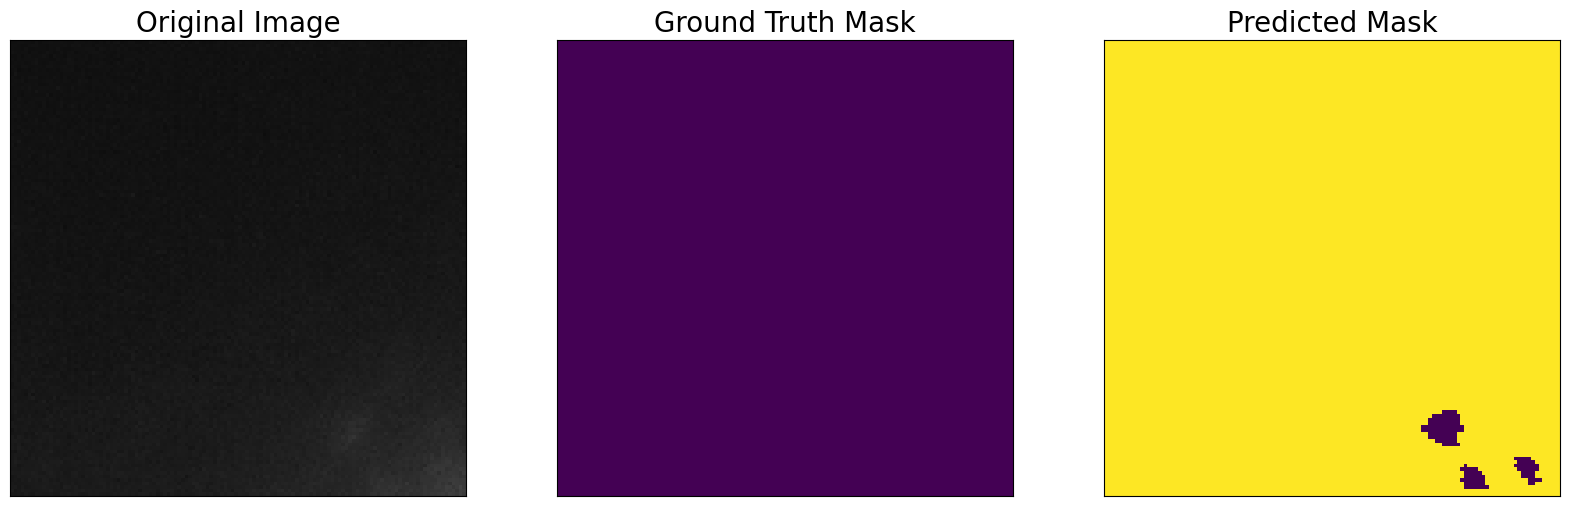

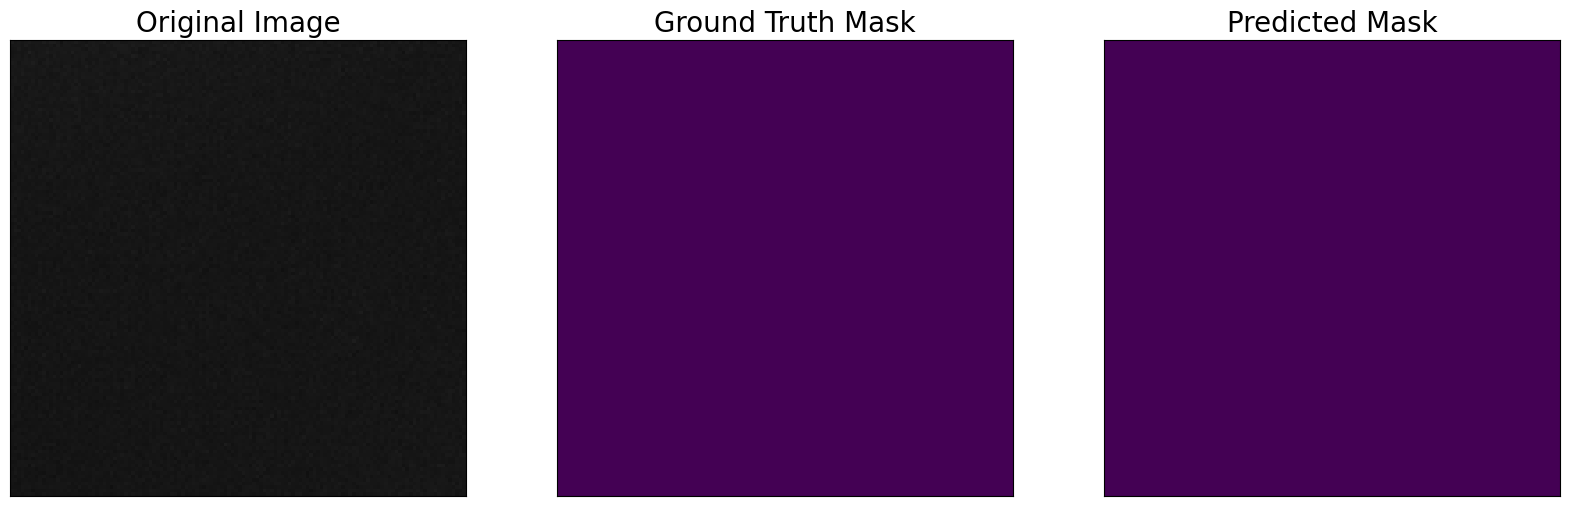

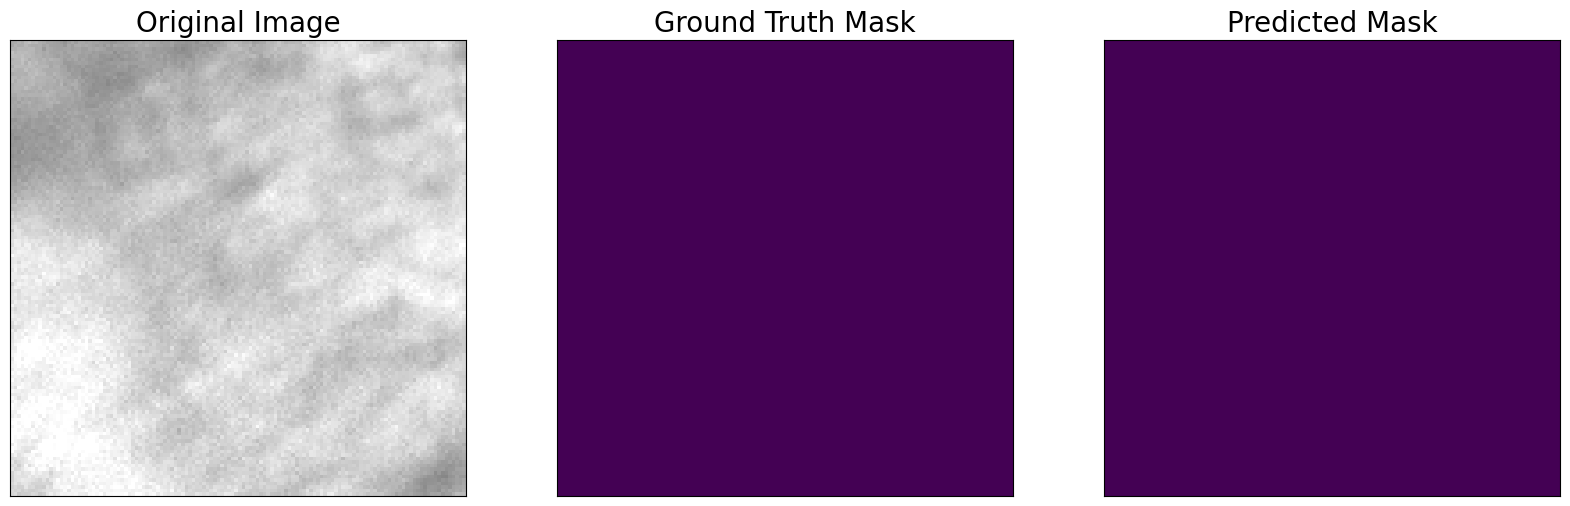

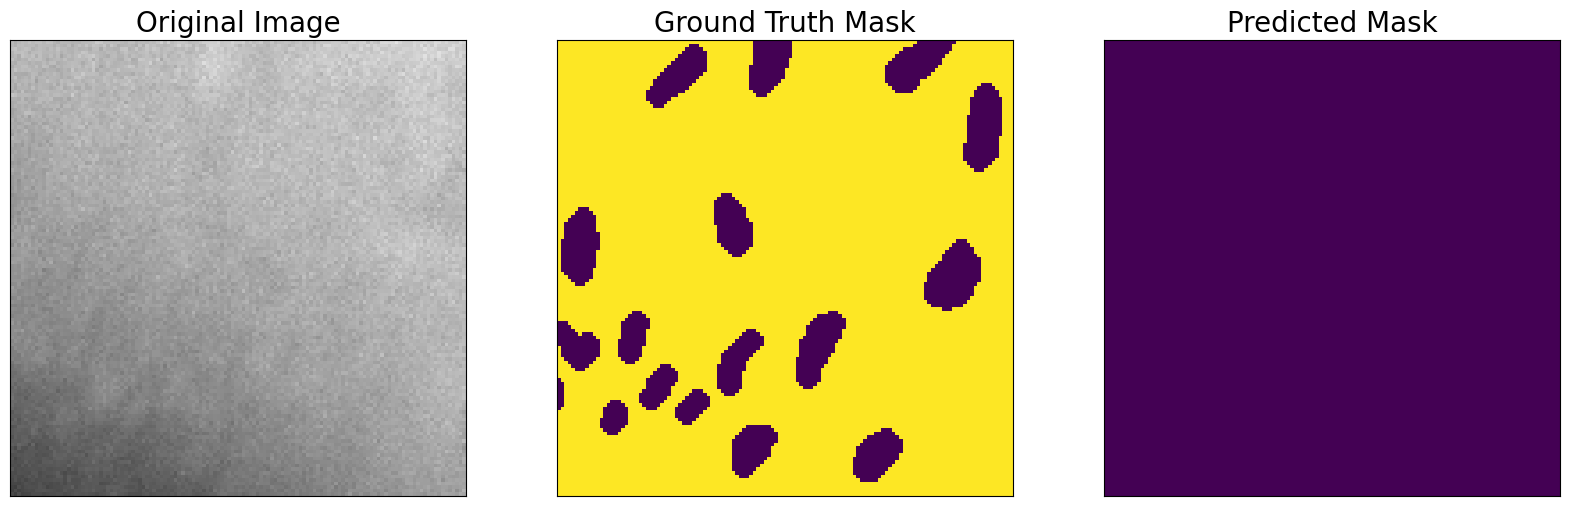

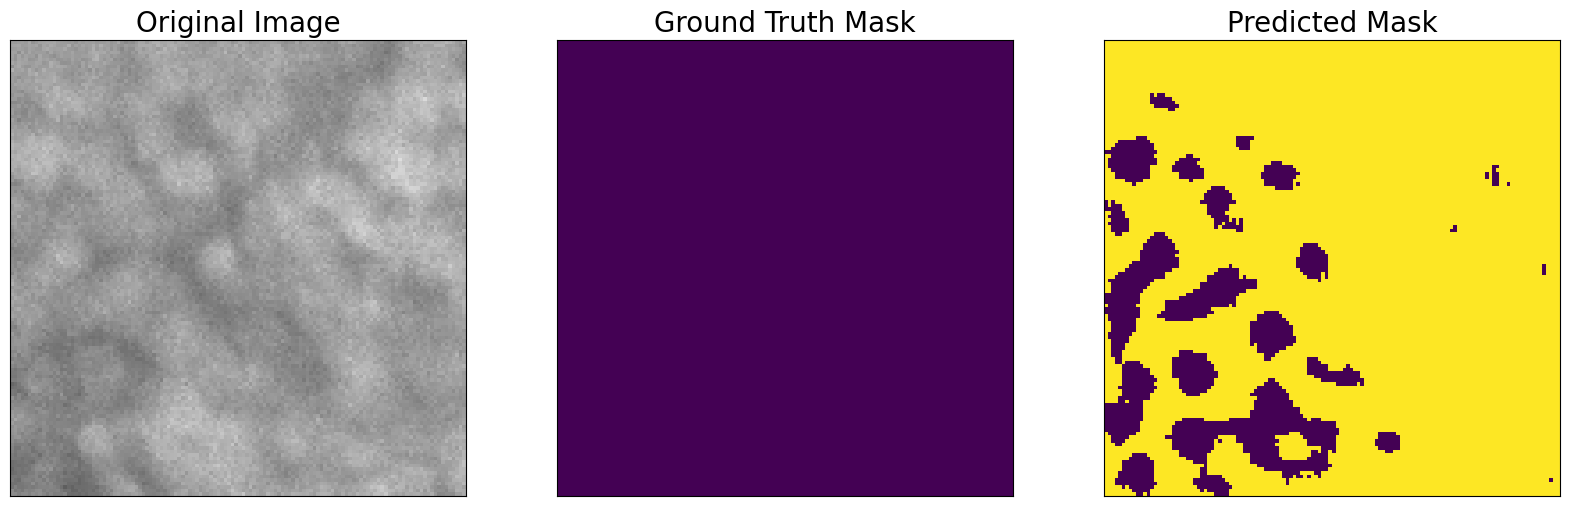

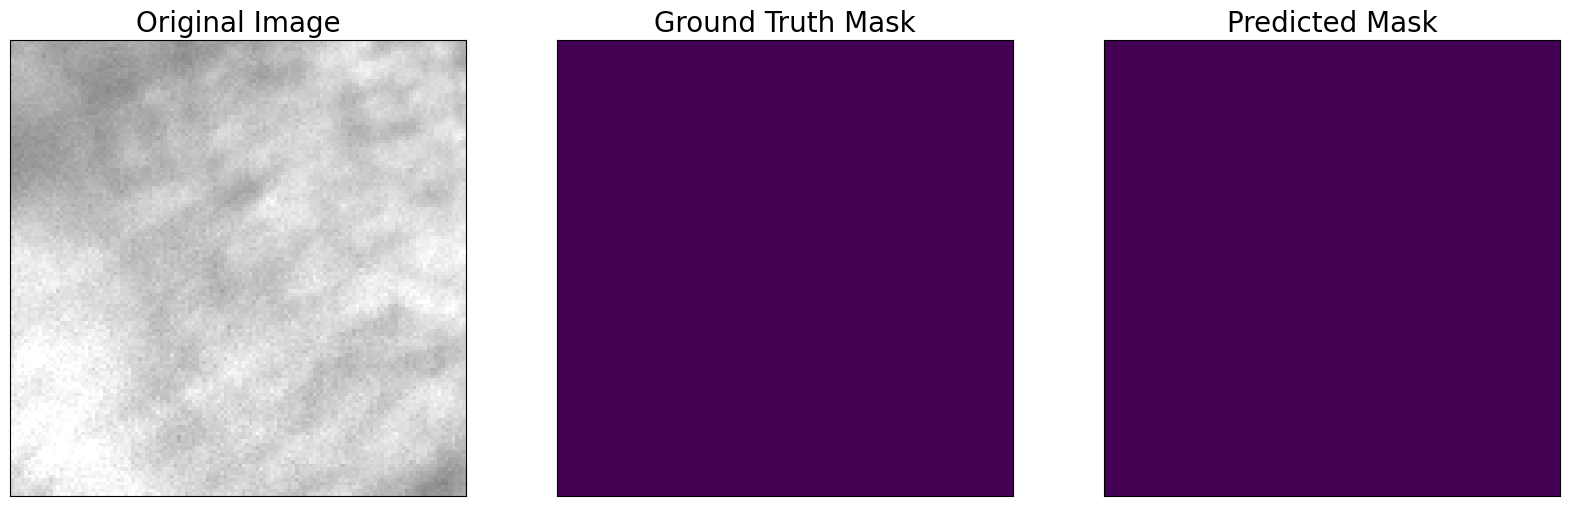

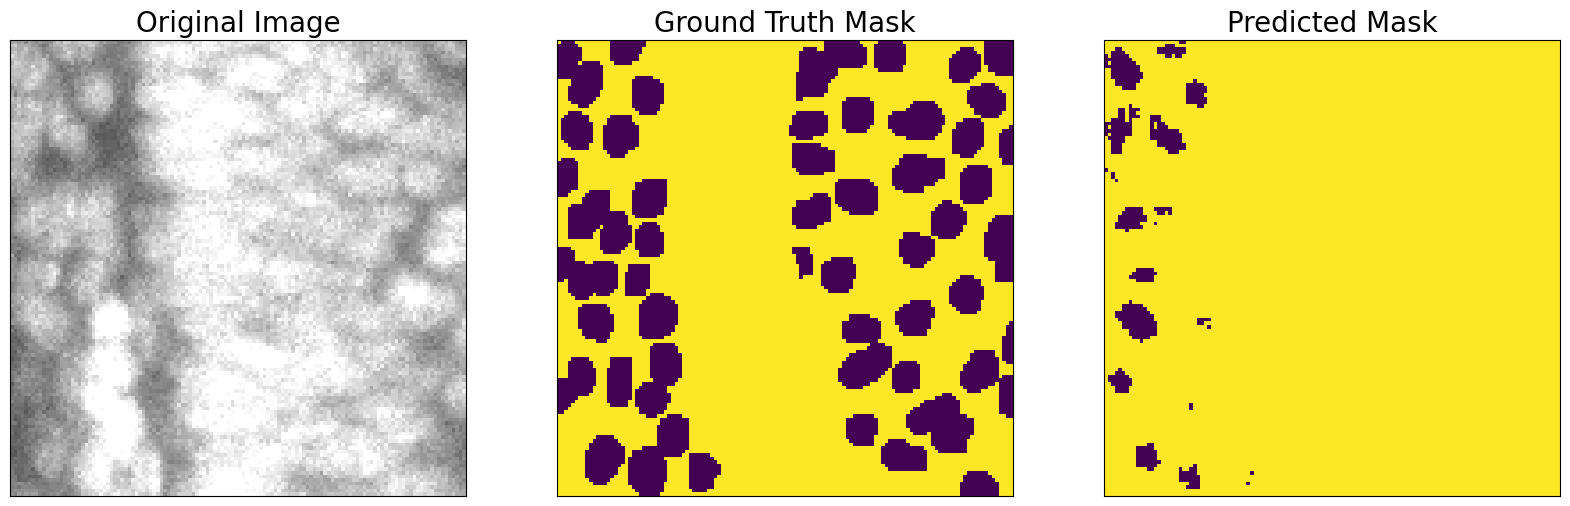

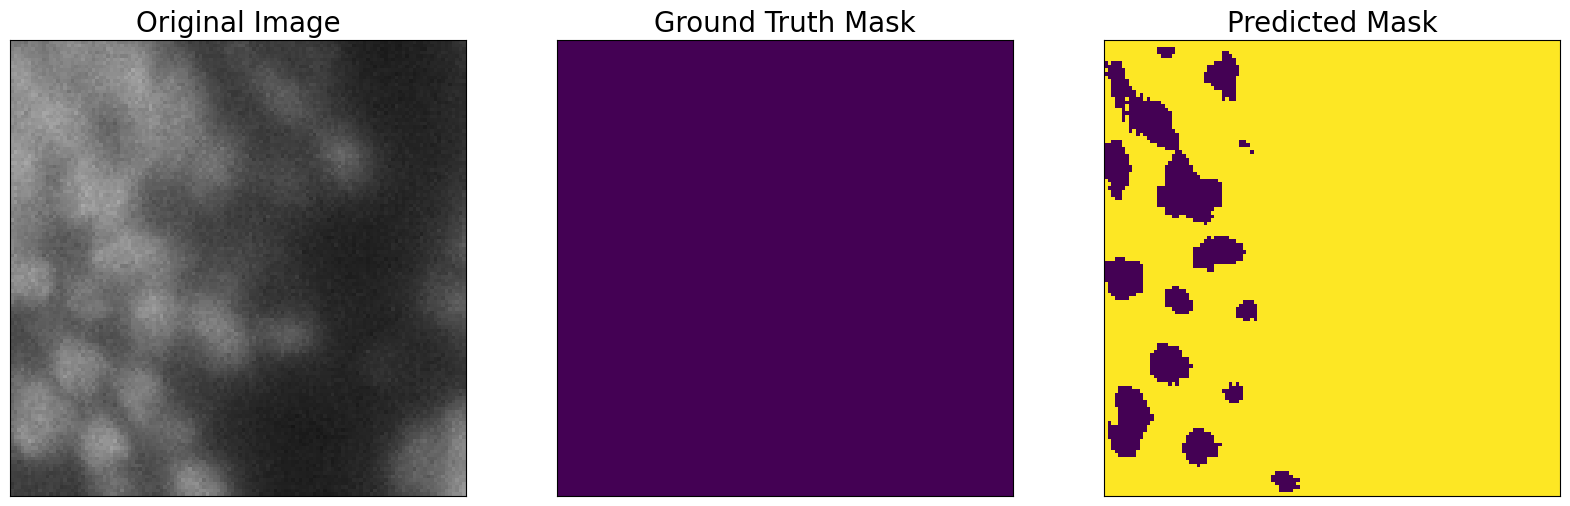

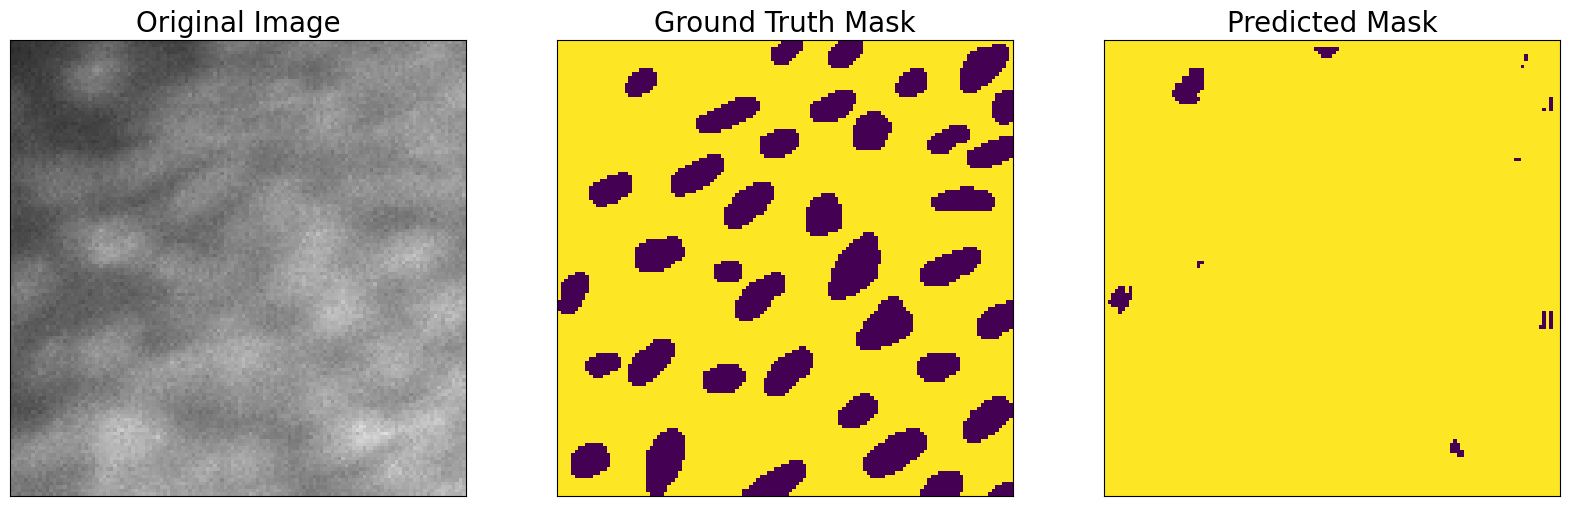

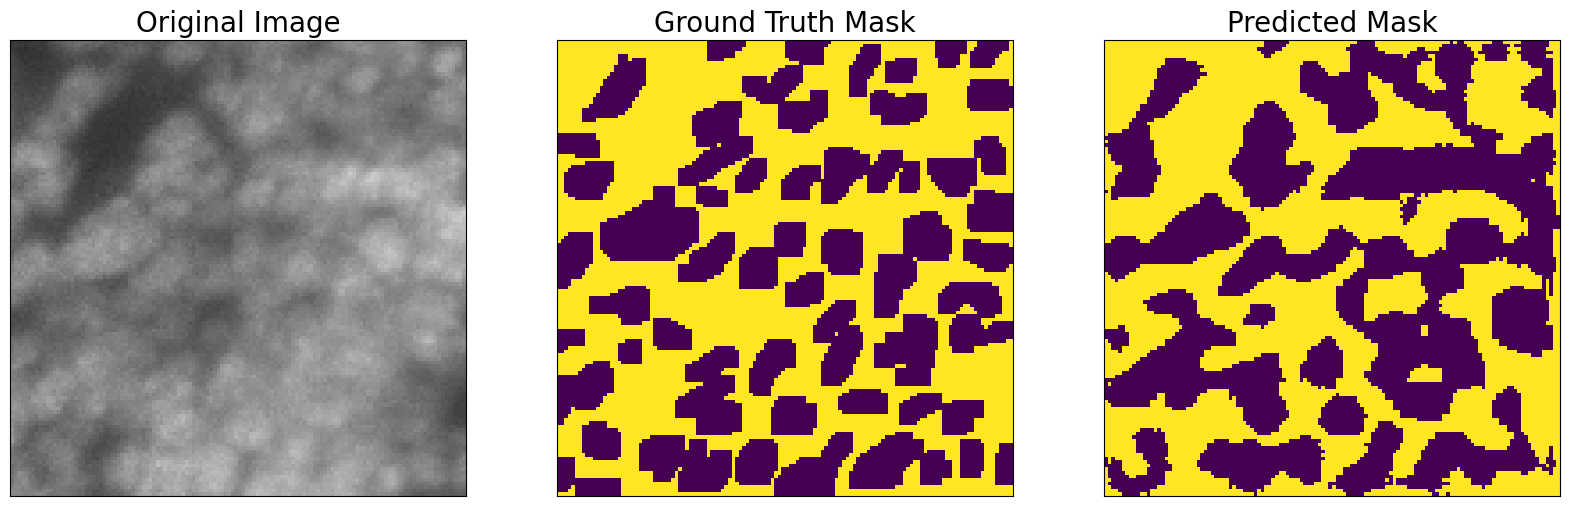

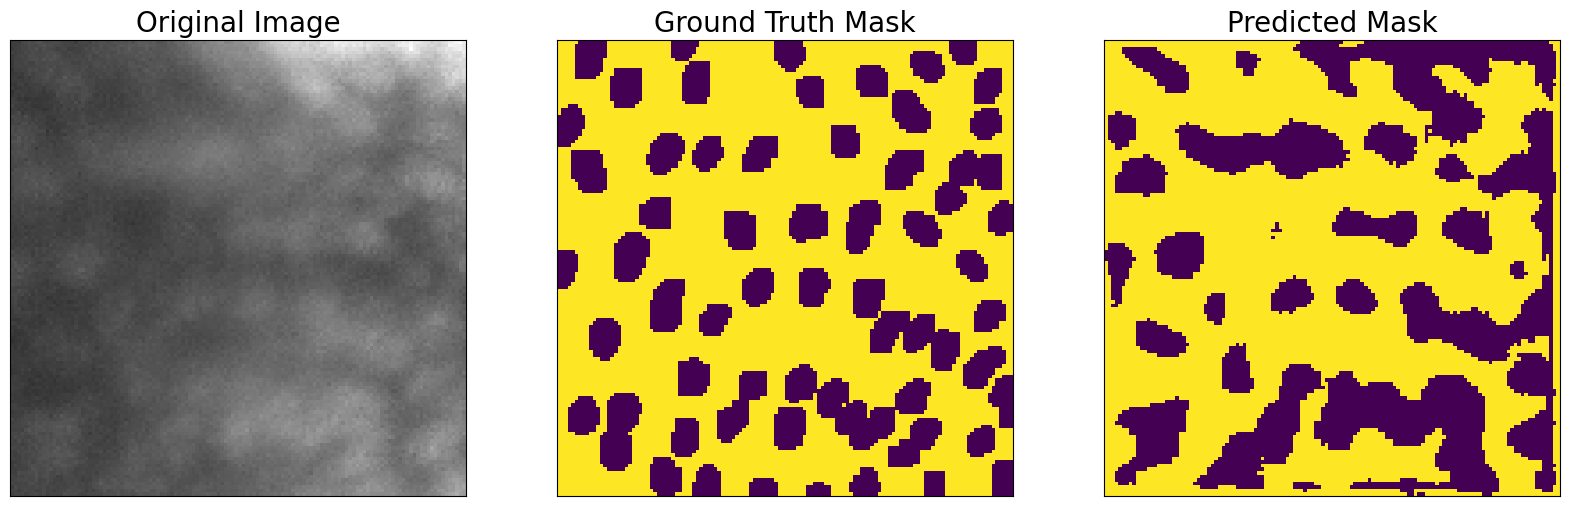

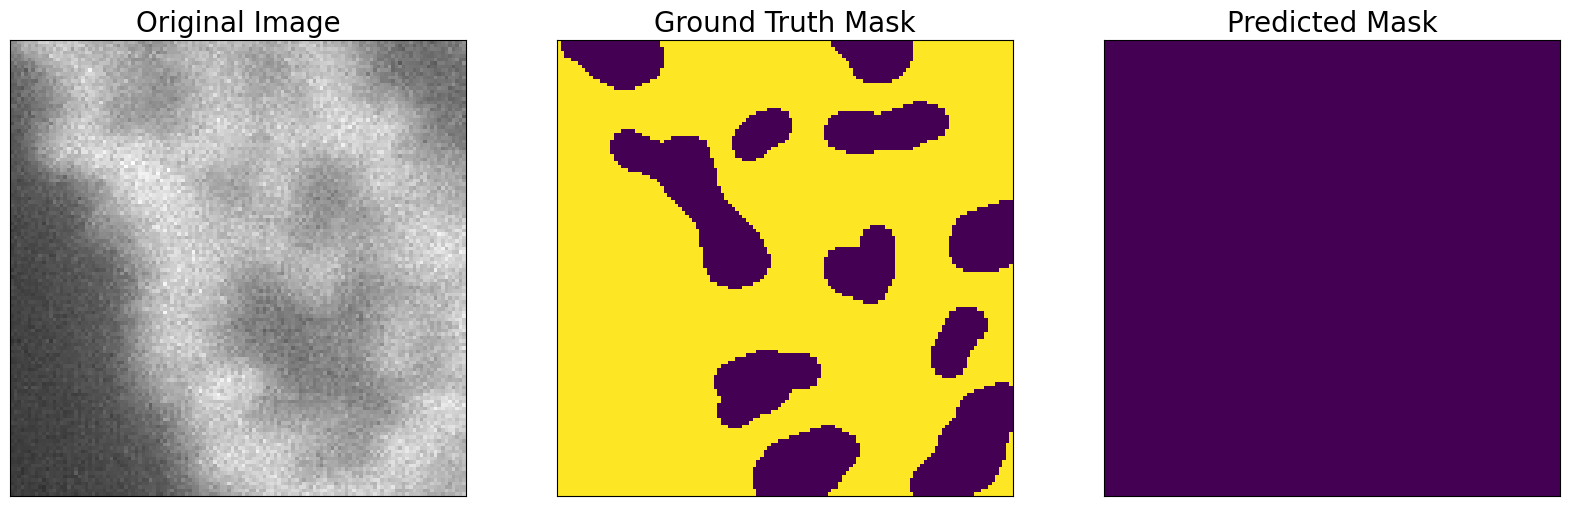

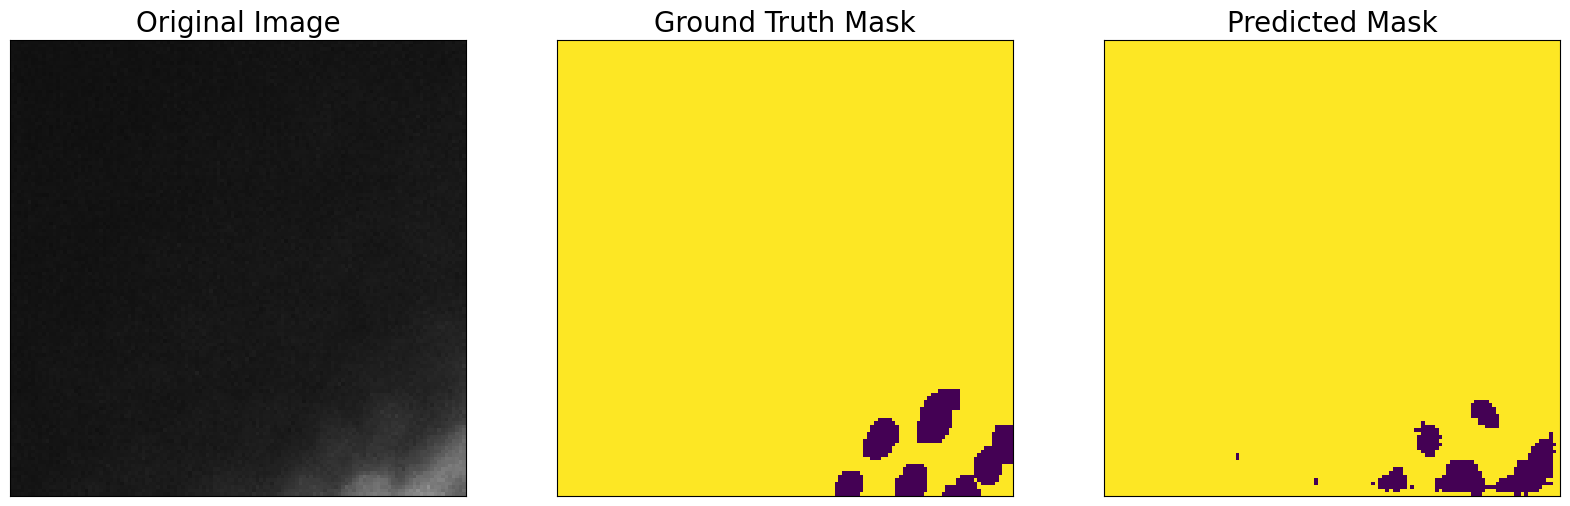

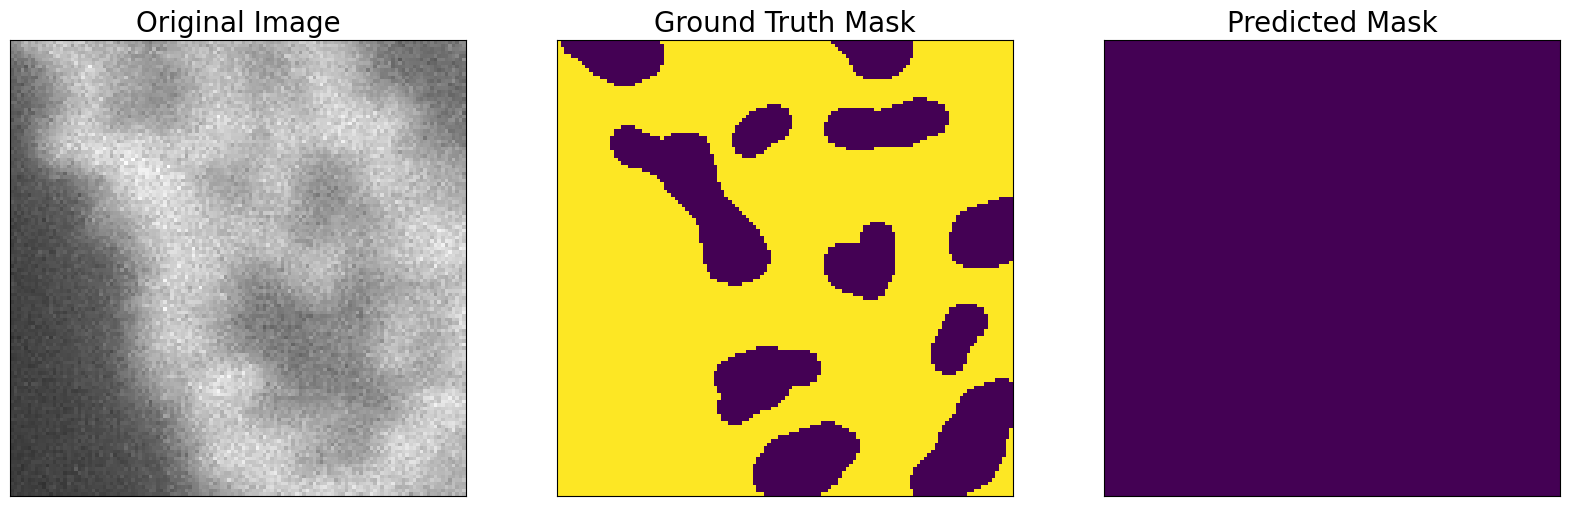

In [43]:
pred = np.zeros([len(test_dataset),128,128])
gt = np.zeros([len(test_dataset),128,128])

for idx in range(len(test_dataset)):

    random_idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[random_idx]
    image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred[idx] = reverse_one_hot(pred_mask)
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('cell')]
    # pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    # gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    gt[idx] = reverse_one_hot(gt_mask)
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = reverse_one_hot(gt_mask),
        predicted_mask = reverse_one_hot(pred_mask),
        # predicted_building_heatmap = pred_building_heatmap
    )

In [57]:
import numpy as np

def iou(y_true, y_pred, label):
    """
    Calculate Intersection over Union (IoU) for a given label.
    Parameters:
    y_true (1D array): Ground truth (correct) labels, with shape (width*height,)
    y_pred (1D array): Predicted labels, with shape (width*height,)
    label (int): Label to calculate IoU for
    Returns:
    float: The IoU for the given label
    """
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    intersection = np.sum((y_true == label) & (y_pred == label))
    union = np.sum((y_true == label) | (y_pred == label))
    if union == 0:
        return 0
    else:
        return intersection / union

def precision_recall_fscore(y_true, y_pred):
    """
    Calculate precision, recall, and F-score for all classes.
    Parameters:
    y_true (2D array): Ground truth (correct) labels, with shape (width, height)
    y_pred (2D array): Predicted labels, with shape (width, height)
    Returns:
    tuple: (precision, recall, fscore), with shape (2,), one for each class (background, cell)
    """
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    precision = []
    recall = []
    fscore = []
    for label in range(2):
        tp = np.sum((y_true == label) & (y_pred == label))
        fp = np.sum((y_true != label) & (y_pred == label))
        fn = np.sum((y_true == label) & (y_pred != label))
        if tp + fp == 0:
            p = 0
        else:
            p = tp / (tp + fp)
        if tp + fn == 0:
            r = 0
        else:
            r = tp / (tp + fn)
        if p + r == 0:
            f = 0
        else:
            f = 2 * p * r / (p + r)
        precision.append(p)
        recall.append(r)
        fscore.append(f)
    return np.array(precision), np.array(recall), np.array(fscore)

# Example usage
precision_cell = []
recall_cell = []
fscore_cell = []
iou_cell = []
precision_bg = []
recall_bg = []
fscore_bg = []
iou_bg_1 = []
for i in range(len(pred)):
  iou_bg = iou(gt[i], pred[i], 0.0)
  iou_class1 = iou(gt[i], pred[i], 1.0)

  precision, recall, fscore = precision_recall_fscore(gt[i], pred[i])
  precision_cell.append(precision[1])
  recall_cell.append(recall[1])
  fscore_cell.append(fscore[1])
  iou_cell.append(iou_class1)
  precision_bg.append(precision[0])
  recall_bg.append(recall[0])
  fscore_bg.append(fscore[0])
  iou_bg_1.append(iou_bg)

print("IoU Cell:" + str(np.mean(iou_cell)))
print("Fscore Cell:" + str(np.mean(fscore_cell)))
print("Precision Cell:" + str(np.mean(precision_cell)))
print("Recall Cell:" + str(np.mean(recall_cell)))

print("IoU Cell:" + str(np.mean(iou_bg_1)))
print("Fscore Cell:" + str(np.mean(fscore_bg)))
print("Precision Cell:" + str(np.mean(precision_bg)))
print("Recall Cell:" + str(np.mean(recall_bg)))

print("IoU overall:" +str((np.mean(iou_bg_1)+np.mean(iou_cell))/2))
print("Fscore overall:" +str((np.mean(fscore_bg)+np.mean(fscore_cell))/2))
print("Precision overall:" +str((np.mean(precision_bg)+np.mean(precision_cell))/2))
print("Recall overall:" +str((np.mean(recall_bg)+np.mean(recall_cell))/2))


IoU Cell:0.8445648690418508
Fscore Cell:0.9081767162562835
Precision Cell:0.88859439294455
Recall Cell:0.9466929122173844
IoU Cell:0.12440848610628866
Fscore Cell:0.17047093234218302
Precision Cell:0.30435240300910776
Recall Cell:0.15903705289273476
IoU overall:0.4844866775740697
Fscore overall:0.5393238242992333
Precision overall:0.5964733979768289
Recall overall:0.5528649825550596


In [58]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5   \
bce_loss   0.645820  0.575881  0.527996  0.492873  0.465696  0.460132   
fscore     0.651426  0.750700  0.798982  0.825552  0.847540  0.832231   
iou_score  0.483752  0.602687  0.667540  0.704505  0.736604  0.713873   
precision  0.641776  0.731389  0.781855  0.811626  0.833189  0.817759   
recall     0.661420  0.771083  0.816969  0.839993  0.862420  0.847249   

                 6         7         8         9   ...        18        19  \
bce_loss   0.444745  0.412115  0.396011  0.381824  ...  0.305889  0.300703   
fscore     0.846299  0.869375  0.870930  0.881747  ...  0.895167  0.893885   
iou_score  0.736838  0.771953  0.772924  0.790929  ...  0.812238  0.809385   
precision  0.835001  0.858853  0.867138  0.878221  ...  0.896148  0.895703   
recall     0.857921  0.880189  0.874763  0.885305  ...  0.894194  0.892078   

                 20        21        22        23        24        25  \
bce_loss   0.297950  0.292526  0.301778  0.278422  0.278967  0.270426   
fscore     0.896521  0.895440  0.889717  0.903085  0.892366  0.898604   
iou_score  0.814007  0.812665  0.805207  0.825293  0.807248  0.816814   
precision  0.896792  0.895757  0.890474  0.903788  0.893384  0.899084   
recall     0.896250  0.895124  0.888962  0.902388  0.891352  0.898126   

                 26        27  
bce_loss   0.272100  0.262069  
fscore     0.896312  0.905888  
iou_score  0.813142  0.829698  
precision  0.896412  0.905455  
recall     0.896213  0.906324  

[5 rows x 28 columns]

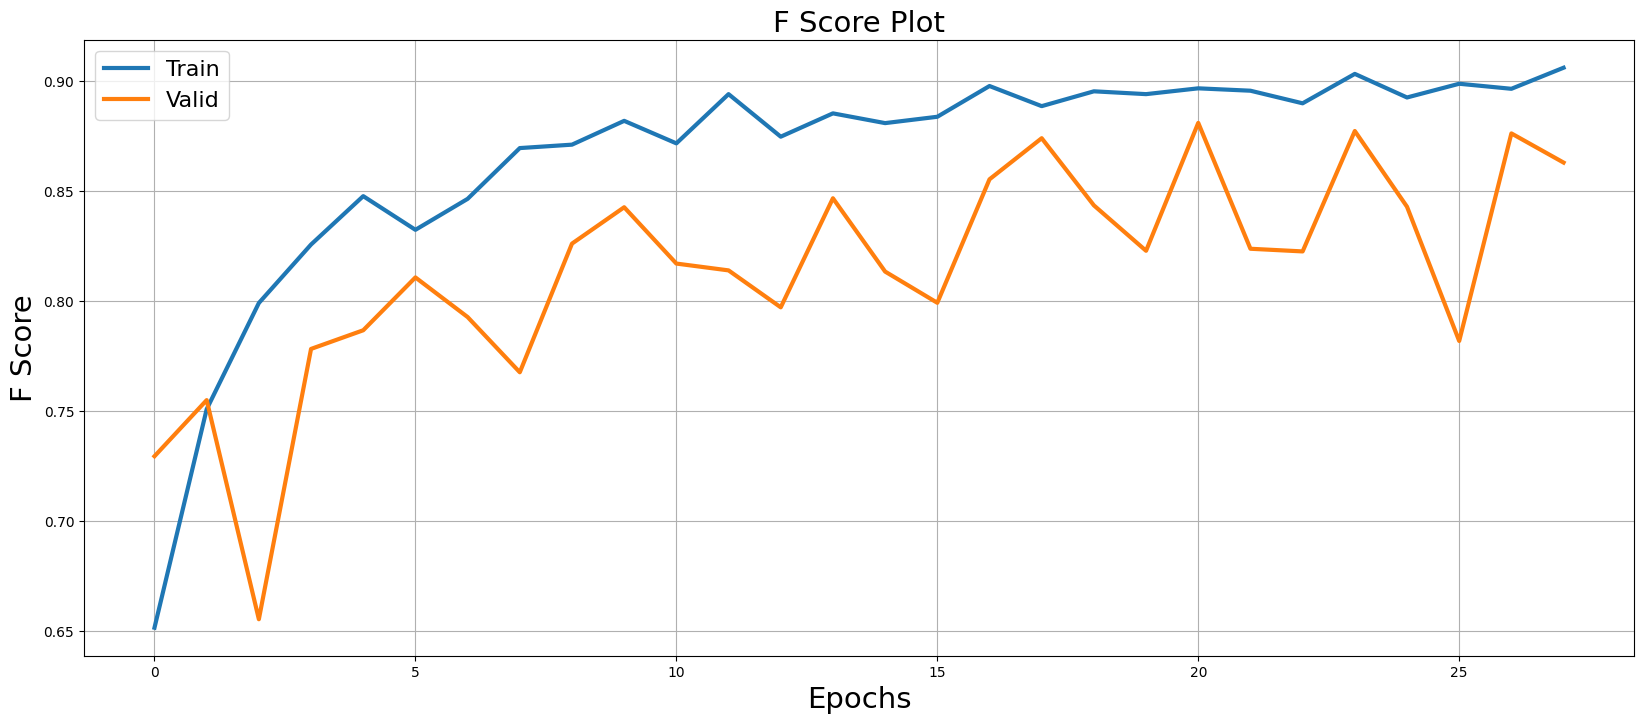

In [59]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('F Score', fontsize=21)
plt.title('F Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('F_score_plot.png')
plt.show()

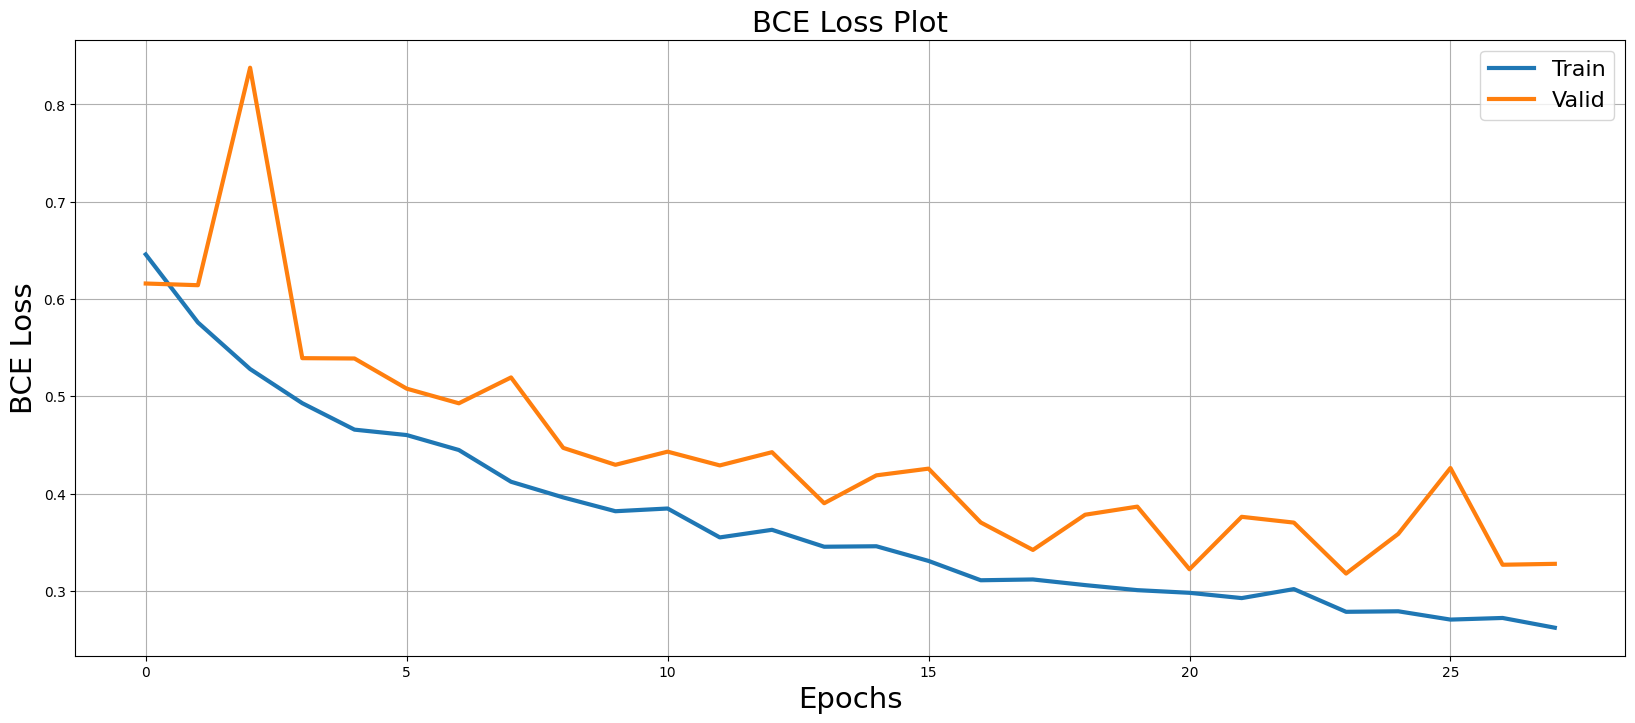

In [60]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.bce_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.bce_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('BCE Loss', fontsize=21)
plt.title('BCE Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('bce_loss_plot.png')
plt.show()